In [1]:
# =============================================================================
# NOTEBOOK SETUP - Two Population Delay Sweep Execution
# =============================================================================
import os
import sys
from pathlib import Path

# Robust directory setup
if Path.cwd().name == 'two_populations':
    os.chdir("../../")

from src.two_populations.helpers.logger import setup_logger

logger = setup_logger(
    experiment_name="test_delays",
    console_level="DEBUG",
    log_to_file=False
)


logger.info(f"Working directory: {Path.cwd()}")
logger.info(f"Python path: {sys.path[0]}")

INFO     | __main__:<module>:21 - Working directory: /home/ubuntu-deduce/Projects/izhikevich
INFO     | __main__:<module>:22 - Python path: /home/ubuntu-deduce/.asdf/installs/python/3.10.13/lib/python310.zip


In [ ]:
from src.two_populations.model import IzhikevichNetwork
import numpy as np
from src.two_populations.model import IzhikevichNetwork
from src.two_populations.metrics import analyze_simulation_results, print_network_statistics_table
from src.two_populations.plots.dashboard_plots import plot_connectivity_dashboard, plot_population_dashboard
from brian2 import * 

# =============================================================================
# SINGLE SIMULATION CONFIGURATION
# =============================================================================

k_factor = 20.0
noise_int = 5.0 #*0.9 #5.1*0.85
noise_inh_factor = 0.45 #5
intra_delay = 0.0
p_intra = 0.1
Ni = 200
Ne = 800
time = 3500

# Simulation parameters
SIM_CONFIG = {
    'dt_ms': 0.1,
    'T_ms': time,
    'warmup_ms': 500
}


# Network parameters
NETWORK_PARAMS = {
    'pop_A': {
        'Ne': Ne, 'Ni': Ni,
        'k_exc': k_factor, 'k_inh': k_factor*3.9,
        'noise_exc': 0.884131778925051, 
        'noise_inh': 0.6041873715553614,
        'p_intra': 0.1, 
        'delay': 0.0,
        'rate_hz':10.106089400313447,
        'stim_start_ms':500.0, 'stim_duration_ms': 100,
        'stim_base': 0.0, 
        'stim_elevated': 3.0
    }
}

# NETWORK_PARAMS = {
#     'pop_A': {
#         'Ne': Ne, 'Ni': Ni,
#         'k_exc': k_factor, 'k_inh': k_factor* 3.9,
#         'noise_exc': noise_int, 'noise_inh': noise_int*noise_inh_factor,
#         'p_intra': p_intra, 'delay': intra_delay,
#         'noise_type': 'gaussian',  # 'poisson', 'gaussian', 'step', 'none'
#         'step': True,
#         'stim_start_ms':500.0, 'stim_duration_ms': 250,
#         'stim_base': 0.2, 
#         'stim_elevated': 1.0
#     }
# }

logger.info("Simulation configured:")
logger.info(f"  Duration: {SIM_CONFIG['T_ms']}ms, dt: {SIM_CONFIG['dt_ms']}ms")

# =============================================================================
# RUN SINGLE SIMULATION
# =============================================================================

start_scope()

# Create network
network = IzhikevichNetwork(
    dt_val=SIM_CONFIG['dt_ms'],
    T_total=SIM_CONFIG['T_ms'],
    fixed_seed=100,
    variable_seed=200,
    trial=0
)


pop_A = network.create_population2(name='A', **NETWORK_PARAMS['pop_A'])
# Caso 1: Silencio + pulso de 50ms
# pop_A = network.create_population('A', **NETWORK_PARAMS['pop_A'])


# Setup monitors and run
network.setup_monitors(['A'], record_v_dt=0.5, sample_fraction=0.5)
results = network.run_simulation()

# Quick check
logger.info(f"\n{'='*50}")
logger.info("SIMULATION COMPLETED")
logger.info(f"{'='*50}")
logger.info(f"Population A: {len(results['A']['spike_times'])} spikes")
logger.info(f"Recording shape: {results['A']['potentials'].shape}")


# =============================================================================
# ANALYSIS WITH VALIDATION
# =============================================================================
from src.two_populations.metrics import analyze_simulation_results

# Analyze connectivity
results_dict = {
    'baseline': analyze_simulation_results(
        spike_mon_A = results['A']['spike_monitor'], 
        spike_mon_B = None,  
        N = Ne + Ni, 
        condition_name="test",
        warmup=SIM_CONFIG['warmup_ms'],
        state_monitors={'A': network.monitors['A']},
        delays=None, 
        signal_mode='lfp',
        T_total=SIM_CONFIG['T_ms']
    )
}

In [ ]:
from src.two_populations.plots.basic_plots import plot_all_basic_analysis
from src.two_populations.plots.basic_plots import plot_raster_results

fig = plot_raster_results(results)

fig = plot_population_dashboard(results_dict)

In [ ]:
results_dict['baseline']['time_series']['fr_A'].mean()

In [ ]:
exc_mask = (results_dict['baseline']['spike_neurons_A'] < 800)

inh_spikes = results_dict['baseline']['spike_times_A'][~exc_mask]
exc_spikes = results_dict['baseline']['spike_times_A'][exc_mask]

warmup_mask = (inh_spikes > 500.0)
inh_spikes = inh_spikes[warmup_mask]

warmup_mask = (exc_spikes > 500.0)
exc_spikes = exc_spikes[warmup_mask]


np.shape(inh_spikes)[0]/3000.0 , np.shape(exc_spikes)[0]/3000.0, (np.shape(inh_spikes)[0]/3000.0 + np.shape(exc_spikes)[0]/3000.0)/2.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from src.two_populations.metrics import analyze_ISI, estimate_intrinsic_refractoriness

# Uso:
isi_exc, isi_inh = analyze_ISI(results['A']['spike_monitor'], Ne, Ni, t_start=500*ms)

In [ ]:
# 1. Corre simulación SIN refractory
# 2. Estima refractariedad intrínseca
intrinsic_results, _ = estimate_intrinsic_refractoriness(
    results['A']['spike_monitor'], Ne, Ni, t_start=500*ms
)

In [ ]:
from src.two_populations.plots.basic_plots import plot_voltage_traces

plot_voltage_traces(results_dict, results, (500,1500) , 3 , 3, True, 3)

In [ ]:
def compute_steady_state_fr(results_dict, start_ms=1500, duration_ms=1000):
    """
    Calcula FR promedio en ventana temporal post-estímulo.
    
    Args:
        results_dict: Output de analyze_simulation_results
        start_ms: Inicio ventana (ms post-warmup)
        duration_ms: Duración ventana
    
    Returns:
        dict: {condition: {'fr_A': float, 'fr_B': float}}
    """
    fr_stats = {}
    
    for condition, results in results_dict.items():
        ts = results['time_series']
        time = ts['time_fr']
        
        # Máscara temporal
        mask = (time >= start_ms) & (time < start_ms + duration_ms)
        
        # FR promedio
        fr_A_mean = np.mean(ts['fr_A'][mask]) if np.any(mask) else 0.0
        fr_B = ts.get('fr_B')
        fr_B_mean = np.mean(fr_B[mask]) if (fr_B is not None and np.any(mask)) else None
        
        fr_stats[condition] = {
            'fr_A': fr_A_mean,
            'fr_B': fr_B_mean,
            'window_start_ms': start_ms,
            'window_duration_ms': duration_ms,
            'n_samples': np.sum(mask)
        }
    
    return fr_stats



# Parámetros del grid
start_range = np.arange(500, 3500, 50)  # Inicio ventana (post-estímulo)
duration_range = np.arange(25, 2525, 50)  # Duración ventana

fr_grid = np.zeros((len(duration_range), len(start_range)))

for i, duration in enumerate(duration_range):
    for j, start in enumerate(start_range):
        # Verificar que no excede tiempo total
        if start + duration > 3500:  # Ajustar según T_total
            fr_grid[i, j] = np.nan
            continue
        
        fr_steady = compute_steady_state_fr(results_dict, start_ms=start, duration_ms=duration)
        fr_grid[i, j] = fr_steady['baseline']['fr_A']

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(fr_grid, aspect='auto', origin='lower', 
               extent=[start_range[0], start_range[-1], duration_range[0], duration_range[-1]],
               cmap='viridis')
ax.set_xlabel('Start time (ms)', fontsize=12)
ax.set_ylabel('Window duration (ms)', fontsize=12)
ax.set_title('Steady-state FR vs temporal window', fontsize=14)
plt.colorbar(im, ax=ax, label='FR (Hz)')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from brian2 import start_scope
from src.two_populations.model import IzhikevichNetwork
from src.two_populations.metrics import analyze_simulation_results

# Setup con estilo mejorado
# plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(12, 6))
fr_all = defaultdict(list)

start_range = np.arange(500, 3000, 20)
duration = 200

# Colores más distinguibles
k_values = [13, 14.0, 15] #18, 19.6, 22
colors = ['#2E86AB', '#A23B72', '#F18F01']  # azul, rojo, verde
labels = ['Subcritical', 'Critical', 'Supercritical']

for (k_value, color, label) in zip(k_values, colors, labels):
    for trial in range(5):
        SIM_CONFIG = {
            'dt_ms': 0.1,
            'T_ms': 3500,
            'warmup_ms': 500
        }

        NETWORK_PARAMS = {
            'pop_A': {
                'Ne': 800, 'Ni': 200,
                'k_exc': k_value, 'k_inh': k_value*3.9,
                'noise_exc': 0.884131778925051, 
                'noise_inh': 0.6041873715553614,
                'p_intra': 0.1, 
                'delay': 0.0,
                'rate_hz': 10.106089400313447,
                'stim_start_ms': 500.0, 
                'stim_duration_ms': 100,
                'stim_base': 0.0, 
                'stim_elevated': 3.0
            }
        }

        start_scope()
        network = IzhikevichNetwork(
            dt_val=SIM_CONFIG['dt_ms'],
            T_total=SIM_CONFIG['T_ms'],
            fixed_seed=100,
            variable_seed=200,
            trial=trial
        )

        pop_A = network.create_population2(name='A', **NETWORK_PARAMS['pop_A'])
        network.setup_monitors(['A'], record_v_dt=0.5, sample_fraction=0.5)
        results = network.run_simulation()

        results_dict = {
            'baseline': analyze_simulation_results(
                spike_mon_A=results['A']['spike_monitor'], 
                spike_mon_B=None,  
                N=1000, 
                condition_name="decay",
                warmup=SIM_CONFIG['warmup_ms'],
                state_monitors={'A': network.monitors['A']},
                delays=None, 
                signal_mode='lfp',
                T_total=SIM_CONFIG['T_ms']
            )
        }
        
        fr_grid = np.zeros(len(start_range))
        for i, start in enumerate(start_range):
            fr_steady = compute_steady_state_fr(results_dict, start_ms=start, duration_ms=duration)
            fr_grid[i] = fr_steady['baseline']['fr_A']
        
        fr_all[k_value].append(fr_grid)
        
        # Trials individuales muy tenues
        
        ax.plot(start_range, fr_grid, '-', color=color, alpha=0.2, linewidth=0.85)
    
    # Media gruesa
    mean_fr = np.mean(fr_all[k_value], axis=0)
    std_fr = np.std(fr_all[k_value], axis=0)
    ax.plot(start_range, mean_fr, '-', color=color, linewidth=2.5, label=f'{label} (k={k_value})', zorder=10) #, 
    ax.fill_between(start_range, mean_fr-std_fr, mean_fr+std_fr, color=color, alpha=0.15)

# Estilo
ax.axvline(600, color='#555555', linestyle='--', linewidth=2, 
        label='Stimulus offset', zorder=5)
ax.set_xlabel('Time (ms)', fontsize=13, fontweight='600')
ax.set_ylabel('Firing Rate (Hz)', fontsize=13, fontweight='600')
ax.set_title('Activity Decay Across Criticality Regimes', 
            fontsize=15, fontweight='700', pad=15)
ax.legend(fontsize=10, framealpha=0.98, loc='upper right', frameon=True)
ax.grid(True, alpha=0.3, linewidth=0.5)
ax.set_xlim(500, 3000)
ax.set_ylim(0, 50)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

In [ ]:
# ============= MÉTRICAS CUANTITATIVAS =============
print("\n=== DECAY METRICS ===")
for k_value, label in zip(k_values, labels):
    mean_fr = np.mean(fr_all[k_value], axis=0)
    
    # FR inicial (promedio 600-700ms)
    mask_init = (start_range >= 600) & (start_range < 700)
    fr_init = np.mean(mean_fr[mask_init])
    
    # FR final (promedio 1500-2000ms)
    mask_final = (start_range >= 1500) & (start_range < 2000)
    fr_final = np.mean(mean_fr[mask_final])
    
    # Tiempo al 50% del decay
    fr_50 = fr_init * 0.5
    idx_50 = np.argmin(np.abs(mean_fr - fr_50))
    t_50 = start_range[idx_50] if mean_fr[idx_50] < fr_init else np.nan
    
    print(f"\n{label} (k={k_value}):")
    print(f"  FR initial (600-700ms): {fr_init:.1f} Hz")
    print(f"  FR final (1500-2000ms): {fr_final:.1f} Hz")
    print(f"  Decay: {fr_init - fr_final:.1f} Hz ({100*(fr_init-fr_final)/fr_init:.1f}%)")
    print(f"  t₅₀: {t_50:.0f} ms" if not np.isnan(t_50) else "  t₅₀: >2000 ms")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from brian2 import ms

# =============================================================================
# CÁLCULO DE FR (necesario para heatmap)
# =============================================================================

def compute_steady_state_fr(results_dict, start_ms=1500, duration_ms=1000):
    """Calcula FR promedio en ventana temporal (para heatmap)"""
    fr_stats = {}
    
    for condition, results in results_dict.items():
        ts = results['time_series']
        time = ts['time_fr']
        mask = (time >= start_ms) & (time < start_ms + duration_ms)
        
        fr_A_mean = np.mean(ts['fr_A'][mask]) if np.any(mask) else 0.0
        
        fr_stats[condition] = {
            'fr_A': fr_A_mean,
            'window_start_ms': start_ms,
            'window_duration_ms': duration_ms,
            'n_samples': np.sum(mask)
        }
    
    return fr_stats


def compute_steady_state_fr_by_type(grouped, k_vals, n_trials, 
                                     start_ms=1500, duration_ms=500):
    """Calcula FR_exc, FR_inh, FR_total para cada k"""
    fr_exc_all, fr_inh_all, fr_total_all = [], [], []
    
    for k in k_vals:
        fr_exc_trials, fr_inh_trials, fr_tot_trials = [], [], []
        
        for trial in range(n_trials):
            data = grouped[k][trial]
            
            # Máscara temporal
            t_mask = (data['spike_times']/ms >= start_ms) & \
                     (data['spike_times']/ms < start_ms + duration_ms)
            
            spikes_in_window = data['spike_indices'][t_mask]
            Ne = data['Ne']
            Ni = data['Ni']
            
            # Contar por tipo
            n_exc = np.sum(spikes_in_window < Ne)
            n_inh = np.sum(spikes_in_window >= Ne)
            
            # FR en Hz
            window_s = duration_ms / 1000
            fr_exc_trials.append(n_exc / (Ne * window_s))
            fr_inh_trials.append(n_inh / (Ni * window_s))
            fr_tot_trials.append((n_exc + n_inh) / ((Ne + Ni) * window_s))
        
        fr_exc_all.append((np.mean(fr_exc_trials), np.std(fr_exc_trials)))
        fr_inh_all.append((np.mean(fr_inh_trials), np.std(fr_inh_trials)))
        fr_total_all.append((np.mean(fr_tot_trials), np.std(fr_tot_trials)))
    
    return {
        'exc': np.array(fr_exc_all),
        'inh': np.array(fr_inh_all),
        'total': np.array(fr_total_all)
    }




import multiprocessing as mp
from functools import partial
from src.two_populations.model import IzhikevichNetwork
import numpy as np
from src.two_populations.metrics import analyze_simulation_results, print_network_statistics_table
from src.two_populations.plots.dashboard_plots import plot_connectivity_dashboard, plot_population_dashboard

def run_single_k_trial(args, sim_config, network_params):
    """Worker que retorna time_series para post-procesamiento"""
    k_factor, trial = args
    from brian2 import start_scope
    
    start_scope()
    
    network = IzhikevichNetwork(
        dt_val=sim_config['dt_ms'],
        T_total=sim_config['T_ms'],
        fixed_seed=100,
        variable_seed=200 + trial,
        trial=trial
    )
    
    params = network_params['pop_A'].copy()
    params['k_exc'] = k_factor
    params['k_inh'] = k_factor * 3.9
    
    pop_A = network.create_population2('A', **params)
    network.setup_monitors(['A'], record_v_dt=0.5, sample_fraction=0.5)
    results = network.run_simulation()
    
    full_result = analyze_simulation_results(
        spike_mon_A=results['A']['spike_monitor'],
        spike_mon_B=None,
        N=params['Ne'] + params['Ni'],
        condition_name=f"k={k_factor:.3f}_trial{trial}",
        warmup=sim_config['warmup_ms'],
        state_monitors={'A': network.monitors['A']},
        signal_mode='lfp',
        T_total=sim_config['T_ms']
    )
    
    # Retornar estructura compatible con compute_steady_state_fr
    return {
        'k_factor': k_factor,
        'trial': trial,
        'time_series': full_result['time_series'],
        'spike_times': results['A']['spike_monitor'].t[:],      # ← AÑADIR
        'spike_indices': results['A']['spike_monitor'].i[:],    # ← AÑADIR
        'Ne': params['Ne'],  
        'Ni': params['Ni'],
        'gamma_power': full_result['power_A']['gamma_power'],
    }


noise_int = 5.0 #*0.9 #5.1*0.85
noise_inh_factor = 0.45 #5
intra_delay = 0.0
p_intra = 0.1
Ni = 800
Ne = 200
time = 3000

# Simulation parameters
SIM_CONFIG = {
    'dt_ms': 0.1,
    'T_ms': time,
    'warmup_ms': 500
}

# # Network parameters
NETWORK_PARAMS = {
    'pop_A': {
        'Ne': Ne, 'Ni': Ni,
        'noise_exc': 0.88, 
        'noise_inh': 0.6,
        'p_intra': 0.1, 
        'delay': 0.0,
        'rate_hz':10.1,
        'stim_base':0.0, 'stim_elevated':3.0,
        'stim_start_ms':500.0, 'stim_duration_ms':100.0
    }
}

# # Network parameters
# NETWORK_PARAMS = {
#     'pop_A': {
#         'Ne': Ne, 'Ni': Ni,
#         'noise_exc': noise_int, 'noise_inh': noise_int*noise_inh_factor,
#         'p_intra': p_intra, 'delay': intra_delay,
#         'noise_type': 'gaussian',
#         'step': True,
#         'stim_start_ms': 500.0, 'stim_duration_ms': 500,
#         'stim_base': 0.2, 
#         'stim_elevated': 3.0
#     }
# }

# # Configuración
# Barrido ultra-fino en transiciones
k_pre = np.arange(5, 10, 2.0)           # 3 valores (vs 5)
k_trans1 = np.arange(10, 17, 0.25)       # 70 valores (mantener)
k_inter = np.arange(17, 30, 0.5)        # 26 valores (mantener)
k_trans2 = np.arange(30, 45, 0.5)       # 30 valores (era 75)
k_plateau = np.arange(45, 66, 1.0)      # 21 valores (mantener)

k_factor_values = np.sort(np.concatenate([
    k_pre, k_trans1, k_inter, k_trans2, k_plateau
]))

n_trials = 5
start_range = np.arange(500, 2500, 20)
duration = 200
start = 1600
# Ventanas temporales
time_windows = [(start, duration) for start in start_range if start + duration <= time]

k_trial_pairs = [(k, trial) for k in k_factor_values for trial in range(n_trials)]
n_processes = min(mp.cpu_count() - 1, len(k_trial_pairs))

logger.info(f"Starting sweep: {len(k_factor_values)} k-values × {n_trials} trials")

worker_func = partial(run_single_k_trial, 
                     sim_config=SIM_CONFIG, 
                     network_params=NETWORK_PARAMS)

with mp.Pool(processes=n_processes) as pool:
    results_list = pool.map(worker_func, k_trial_pairs)

# Agrupar por k_factor
from collections import defaultdict
grouped = defaultdict(dict)  # ← dict, no list
for r in results_list:
    grouped[r['k_factor']][r['trial']] = r


INFO     | __main__:<module>:192 - Starting sweep: 108 k-values × 5 trials


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 4, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 216, 'variable_A_current': 216, 'variable_B_current': 219}
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 2, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 208, 'variable_A_current': 208, 'variable_B_current': 211}
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 204, 'variable_A_current': 204, 'variable_B_current': 207}
SUCC

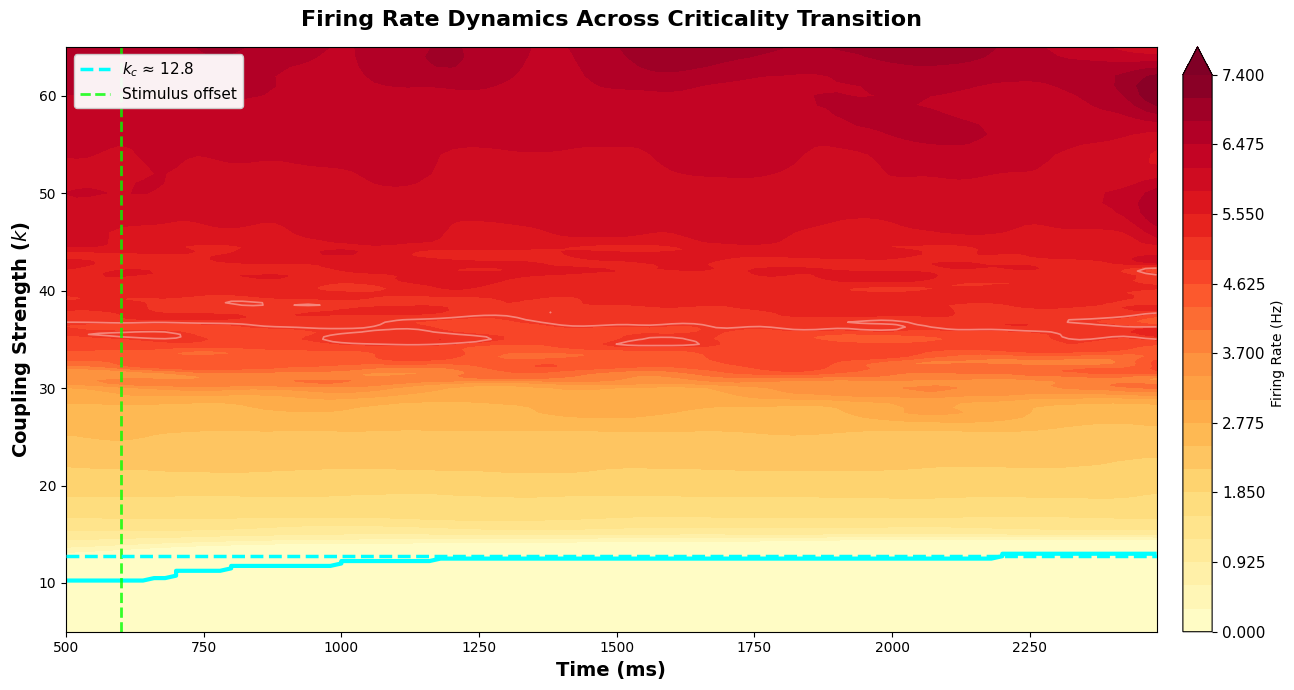

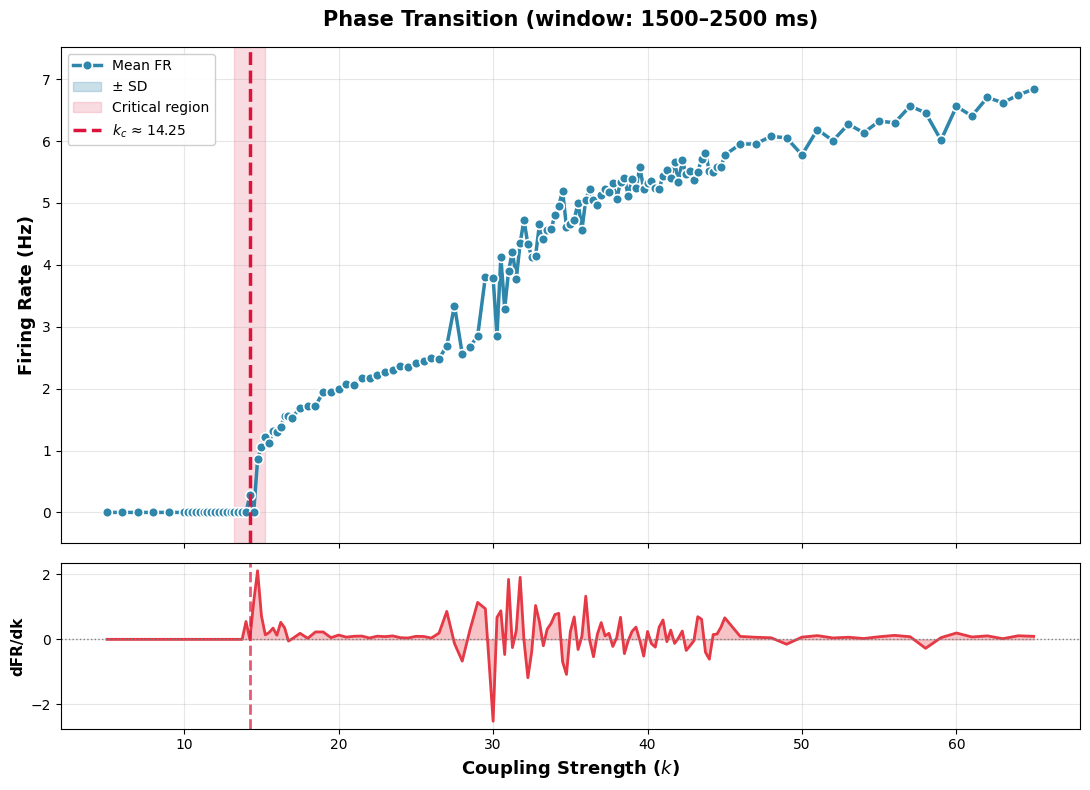


k_c ≈ 14.25 (first k with FR > 0.0 Hz)



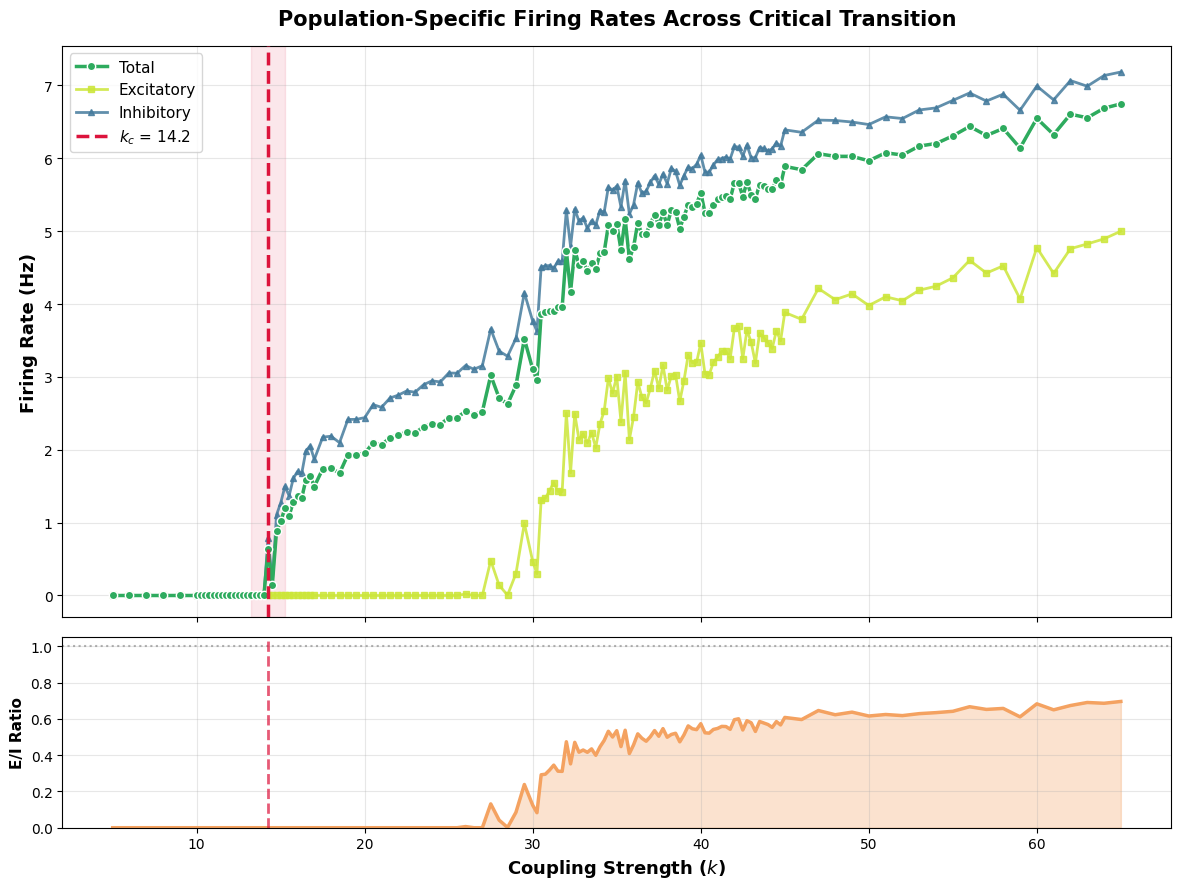

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# =============================================================================
# PLOTS
# =============================================================================

def plot_fr_heatmap(grouped, k_sorted, start_range, duration, time, n_trials, 
                    threshold=0.0, stim_offset=600, save_path='fr_dynamics_heatmap.png'):
    
    fr_matrix = np.zeros((len(k_sorted), len(start_range)))
    
    for i, k in enumerate(k_sorted):
        for j, start in enumerate(start_range):
            if start + duration <= time:
                fr_trials = []
                for trial in range(n_trials):
                    results_dict = {'baseline': grouped[k][trial]}
                    fr_steady = compute_steady_state_fr(
                        results_dict, start_ms=start, duration_ms=duration
                    )
                    fr_trials.append(fr_steady['baseline']['fr_A'])
                fr_matrix[i, j] = np.mean(fr_trials)
    
    fr_matrix_smooth = gaussian_filter(fr_matrix, sigma=1.5)
    
    late_mask = start_range >= 1500
    fr_late = fr_matrix_smooth[:, late_mask].mean(axis=1)
    kc_idx = np.where(fr_late > threshold)[0]
    kc_estimate = k_sorted[kc_idx[0]] if len(kc_idx) > 0 else None
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    levels = np.linspace(0, fr_matrix_smooth.max(), 25)
    im = ax.contourf(start_range, k_sorted, fr_matrix_smooth,
                     levels=levels, cmap='YlOrRd', extend='max')
    
    ax.contour(start_range, k_sorted, fr_matrix_smooth,
               levels=[5, 15, 25, 35], colors='white', alpha=0.4, linewidths=1.2)
    ax.contour(start_range, k_sorted, fr_matrix_smooth, 
               levels=[threshold], colors='cyan', linewidths=3, 
               linestyles='solid')
    
    if kc_estimate:
        ax.axhline(kc_estimate, color='cyan', linestyle='--', linewidth=2.5,
                   label=f'$k_c$ ≈ {kc_estimate:.1f}', zorder=10)
    
    ax.axvline(stim_offset, color='lime', linestyle='--', linewidth=2,
               alpha=0.8, label='Stimulus offset')
    
    ax.set_xlabel('Time (ms)', fontsize=14, fontweight='600')
    ax.set_ylabel('Coupling Strength ($k$)', fontsize=14, fontweight='600')
    ax.set_title('Firing Rate Dynamics Across Criticality Transition',
                 fontsize=16, fontweight='700', pad=15)
    
    cbar = plt.colorbar(im, ax=ax, label='Firing Rate (Hz)', pad=0.02)
    cbar.ax.tick_params(labelsize=11)
    ax.legend(loc='upper left', fontsize=11, framealpha=0.95)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return fr_matrix_smooth, kc_estimate


def plot_fr_vs_k(grouped, n_trials, start=1500, duration=500, 
                 threshold=0.0, save_path='fr_vs_k_transition.png'):
    
    k_vals = []
    fr_means = []
    fr_stds = []

    for k in sorted(grouped.keys()):
        fr_trials = []
        for trial in range(n_trials):
            results_dict = {'baseline': grouped[k][trial]}
            fr_steady = compute_steady_state_fr(results_dict, start_ms=start, 
                                                duration_ms=duration)
            fr_trials.append(fr_steady['baseline']['fr_A'])
        
        k_vals.append(k)
        fr_means.append(np.mean(fr_trials))
        fr_stds.append(np.std(fr_trials))
    
    k_vals = np.array(k_vals)
    fr_means = np.array(fr_means)
    fr_stds = np.array(fr_stds)
    
    kc_idx = np.where(fr_means > threshold)[0]
    kc = k_vals[kc_idx[0]] if len(kc_idx) > 0 else None
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 8), height_ratios=[3, 1], sharex=True)
    
    ax1.plot(k_vals, fr_means, 'o-', linewidth=2.5, markersize=7, 
             color='#2E86AB', markeredgecolor='white', markeredgewidth=1.2,
             label='Mean FR', zorder=5)
    ax1.fill_between(k_vals, fr_means - fr_stds, fr_means + fr_stds,
                     alpha=0.25, color='#2E86AB', label='± SD')
    
    if kc is not None:
        ax1.axvspan(kc - 1, kc + 1, alpha=0.15, color='crimson', label='Critical region')
        ax1.axvline(kc, color='crimson', linestyle='--', linewidth=2.5,
                   label=f'$k_c$ ≈ {kc:.2f}', zorder=10)
    
    ax1.set_ylabel('Firing Rate (Hz)', fontsize=13, fontweight='600')
    ax1.set_title(f'Phase Transition (window: {start}–{start+duration} ms)',
                 fontsize=15, fontweight='700', pad=15)
    ax1.legend(loc='upper left', fontsize=10, framealpha=0.95)
    ax1.grid(alpha=0.3)
    ax1.set_ylim(-0.5, fr_means.max()*1.1)
    
    fr_gradient = np.gradient(fr_means, k_vals)
    ax2.plot(k_vals, fr_gradient, '-', linewidth=2, color='#E63946')
    ax2.axhline(0, color='gray', linestyle=':', linewidth=1)
    ax2.fill_between(k_vals, 0, fr_gradient, alpha=0.3, color='#E63946')
    
    if kc is not None:
        ax2.axvline(kc, color='crimson', linestyle='--', linewidth=2, alpha=0.7)
    
    ax2.set_xlabel('Coupling Strength ($k$)', fontsize=13, fontweight='600')
    ax2.set_ylabel('dFR/dk', fontsize=11, fontweight='600')
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nk_c ≈ {kc:.2f} (first k with FR > {threshold} Hz)\n")
    
    return k_vals, fr_means, fr_stds, kc


def plot_fr_by_type(k_vals, fr_data, kc, save_path='fr_exc_inh_comparison.png'):
    fig, axes = plt.subplots(2, 1, figsize=(12, 9), 
                             height_ratios=[3, 1], sharex=True)
    
    ax1 = axes[0]
    
    # Total
    ax1.plot(k_vals, fr_data['total'][:, 0], 'o-', 
             color="#2EAB5E", linewidth=2.5, markersize=6,
             markeredgecolor='white', markeredgewidth=1,
             label='Total', zorder=3)
    ax1.fill_between(k_vals, 
                     fr_data['total'][:, 0] - fr_data['total'][:, 1],
                     fr_data['total'][:, 0] + fr_data['total'][:, 1],
                     alpha=0.2, color='#2EAB5E')
    
    # Excitatorio
    ax1.plot(k_vals, fr_data['exc'][:, 0], 's-', markersize=5,
             color="#CCE639", linewidth=2, label='Excitatory', alpha=0.85)
    
    # Inhibitorio
    ax1.plot(k_vals, fr_data['inh'][:, 0], '^-', markersize=5,
             color='#457B9D', linewidth=2, label='Inhibitory', alpha=0.85)
    
    if kc is not None:
        ax1.axvline(kc, color='crimson', linestyle='--', linewidth=2.5, 
                    label=f'$k_c$ = {kc:.1f}', zorder=10)
        ax1.axvspan(kc-1, kc+1, alpha=0.1, color='crimson')
    
    ax1.set_ylabel('Firing Rate (Hz)', fontsize=13, fontweight='600')
    ax1.set_title('Population-Specific Firing Rates Across Critical Transition',
                  fontsize=15, fontweight='700', pad=15)
    ax1.legend(loc='upper left', fontsize=11)
    ax1.grid(alpha=0.3)
    ax1.set_ylim(-0.3, None)
    
    # E/I ratio
    ax2 = axes[1]
    ratio = fr_data['exc'][:, 0] / (fr_data['inh'][:, 0] + 1e-9)
    
    ax2.plot(k_vals, ratio, '-', color='#F4A261', linewidth=2.5)
    ax2.fill_between(k_vals, 0, ratio, alpha=0.3, color='#F4A261')
    ax2.axhline(1, color='gray', linestyle=':', linewidth=1.5, alpha=0.6)
    if kc is not None:
        ax2.axvline(kc, color='crimson', linestyle='--', linewidth=2, alpha=0.7)
    
    ax2.set_xlabel('Coupling Strength ($k$)', fontsize=13, fontweight='600')
    ax2.set_ylabel('E/I Ratio', fontsize=11, fontweight='600')
    ax2.grid(alpha=0.3)
    ax2.set_ylim(0, None)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


# =============================================================================
# EJECUCIÓN
# =============================================================================

k_sorted = sorted(grouped.keys())

# Heatmap
fr_matrix, kc_heatmap = plot_fr_heatmap(
    grouped, k_sorted, start_range, duration, time, n_trials, threshold=0.0
)

# FR total
k_vals, fr_means, fr_stds, kc = plot_fr_vs_k(
    grouped, n_trials, start=1500, duration=1000, threshold=0.0
)

# FR por tipo (CALCULAR DATOS PRIMERO)
fr_data = compute_steady_state_fr_by_type(
    grouped, k_vals, n_trials, start_ms=1500, duration_ms=1000
)

plot_fr_by_type(k_vals, fr_data, kc, save_path='fr_exc_inh_comparison.png')

Total simulations: 750
k values: [ 3 10 12 14 16 18 22 30 45 60]
r values: [ 0.5         0.63749776  0.8128068   1.03632503  1.32130978  1.68466405
  2.14793913  2.73861279  3.49171905  4.45192617  5.67618596  7.2371117
  9.22728505 11.76474716 15.        ]
Trials per (k,r): 5

Running with 11 processes...


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 341, 'variable_A_current': 341, 'variable_B_current': 344}
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 3, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 3249, 'variable_A_current': 3249, 'variable_B_current': 3252}
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 4, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 4298, 'variable_A_current': 4298, 'variable_B_current': 4301}
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 1359, 'variable_A_current': 1359, 'variable_B_current': 1

Simulations completed!

DYNAMIC RANGE ANALYSIS

k =   3.0:
  Δ =   7.61 dB
  r_10 =   2.35 Hz  →  F =  0.70 Hz
  r_90 =  13.56 Hz  →  F =  6.26 Hz
  F range =  6.94 Hz
  Max slope dF/dr =  0.522 Hz/Hz
  χ_mid =  0.510 Hz/Hz

k =  10.0:
  Δ =  11.48 dB
  r_10 =   0.89 Hz  →  F =  0.67 Hz
  r_90 =  12.56 Hz  →  F =  5.88 Hz
  F range =  6.50 Hz
  Max slope dF/dr =  2.242 Hz/Hz
  χ_mid =  0.445 Hz/Hz

k =  12.0:
  Δ =  11.18 dB
  r_10 =   0.95 Hz  →  F =  1.33 Hz
  r_90 =  12.48 Hz  →  F =  5.97 Hz
  F range =  5.81 Hz
  Max slope dF/dr =  2.145 Hz/Hz
  χ_mid =  0.419 Hz/Hz

k =  14.0:
  Δ =   9.64 dB
  r_10 =   1.37 Hz  →  F =  1.90 Hz
  r_90 =  12.61 Hz  →  F =  6.11 Hz
  F range =  5.26 Hz
  Max slope dF/dr =  0.822 Hz/Hz
  χ_mid =  0.554 Hz/Hz

k =  16.0:
  Δ =   8.70 dB
  r_10 =   1.69 Hz  →  F =  2.23 Hz
  r_90 =  12.56 Hz  →  F =  6.21 Hz
  F range =  4.98 Hz
  Max slope dF/dr =  0.674 Hz/Hz
  χ_mid =  0.674 Hz/Hz

k =  18.0:
  Δ =   8.81 dB
  r_10 =   1.64 Hz  →  F =  2.47 Hz
  r_

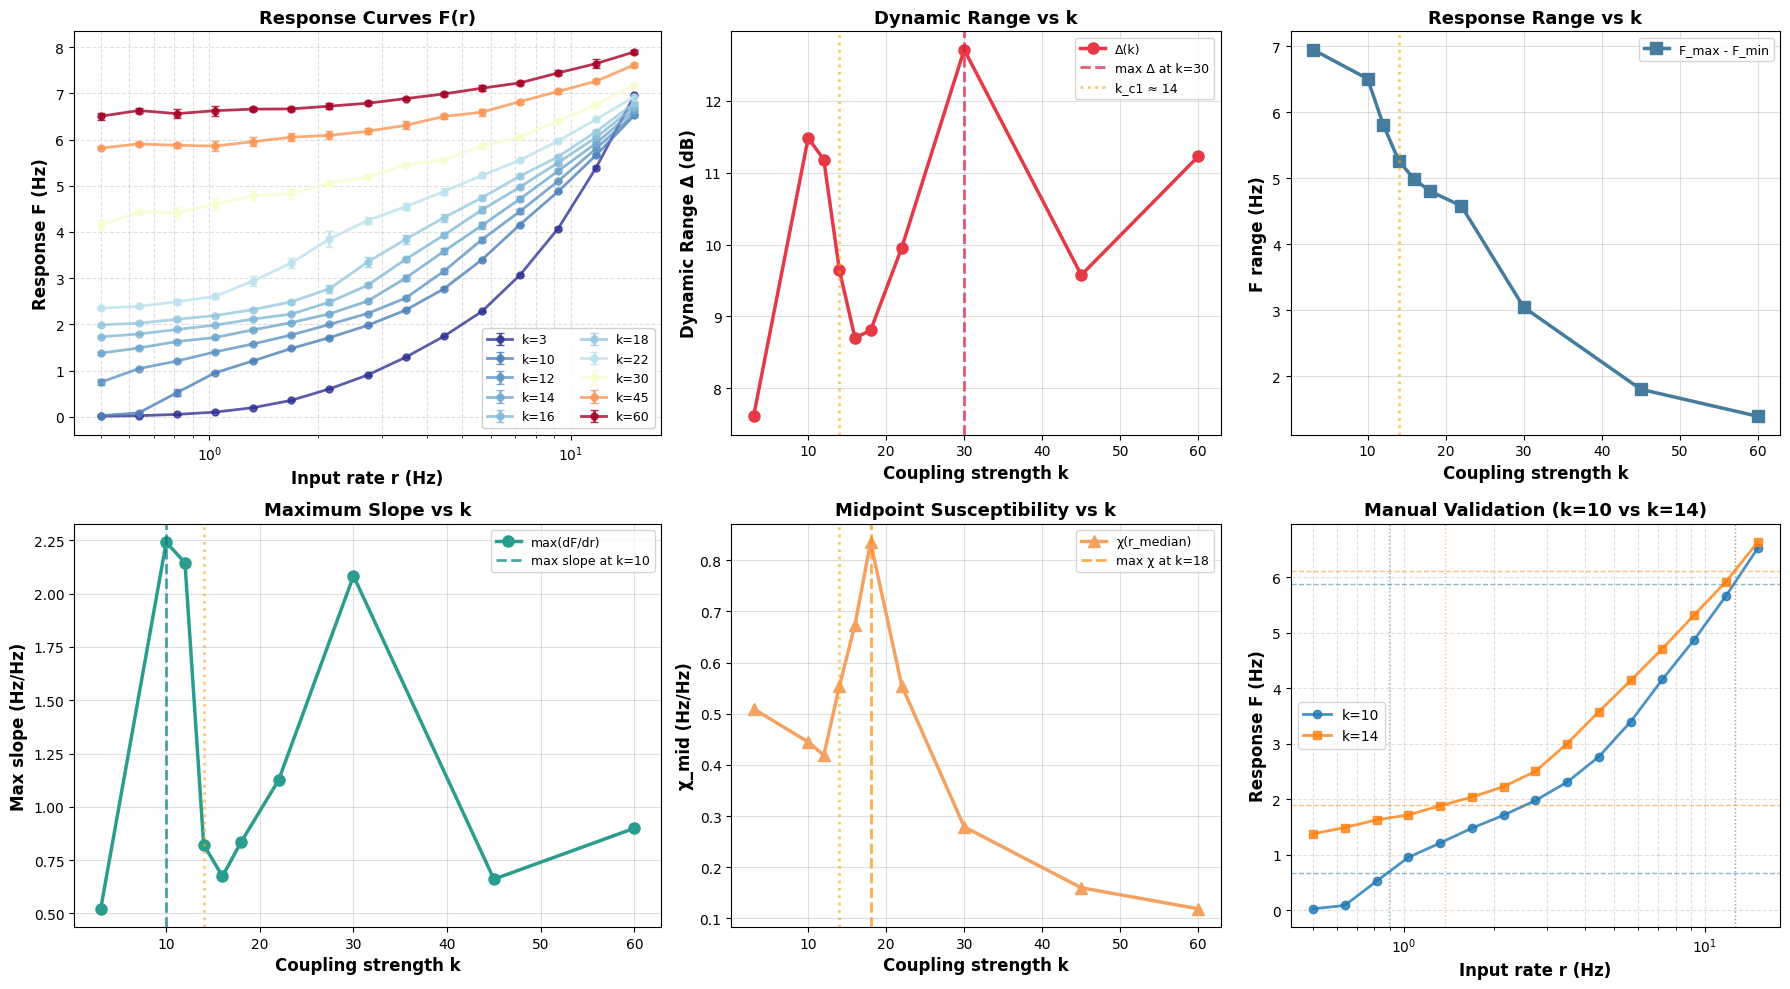


Results saved: criticality_analysis_results.pkl

COMPARATIVE SUMMARY - WHICH k MAXIMIZES EACH METRIC?
Δ (dB)          → k =  30.0  (value =  12.715)
F_range         → k =   3.0  (value =   6.945)
max_slope       → k =  10.0  (value =   2.242)
χ_mid           → k =  18.0  (value =   0.835)

Interpretation:
- If all metrics peak at same k → clear critical point
- If Δ peaks at k_1 but max_slope at k_2 → bifurcation vs criticality


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
from functools import partial
from brian2 import start_scope, ms
from scipy.interpolate import interp1d
from src.two_populations.model import IzhikevichNetwork
from src.two_populations.metrics import analyze_simulation_results

# =============================================================================
# WORKER FUNCTION
# =============================================================================

def run_single_fr_simulation(args, sim_config):
    """Simula una combinación (k, rate_hz, trial)"""
    k_factor, rate_input, trial = args
    
    start_scope()
    
    network = IzhikevichNetwork(
        dt_val=sim_config['dt_ms'],
        T_total=sim_config['T_ms'],
        fixed_seed=100,
        variable_seed=200 + trial * 1000 + int(k_factor * 10) + int(rate_input * 10),
        trial=trial
    )
    
    params = {
        'Ne': 200, 'Ni': 800,
        'k_exc': k_factor,
        'k_inh': k_factor * 3.9,
        'noise_exc': 0.88,
        'noise_inh': 0.6,
        'p_intra': 0.1,
        'delay': 0.0,
        'rate_hz': rate_input,
        'stim_base': 1.0,
        'stim_elevated': None,
        'stim_start_ms': None,
        'stim_duration_ms': None
    }
    
    network.create_population2('A', **params)
    network.setup_monitors(['A'], record_v_dt=0.5, sample_fraction=0.5)
    results = network.run_simulation()
    
    analysis = analyze_simulation_results(
        spike_mon_A=results['A']['spike_monitor'],
        spike_mon_B=None,
        N=1000,
        warmup=sim_config['warmup_ms'],
        state_monitors={'A': network.monitors['A']},
        signal_mode='lfp',
        T_total=sim_config['T_ms']
    )
    
    # CORRECCIÓN: usar toda la ventana post-warmup
    time = analysis['time_series']['time_fr']
    warmup = sim_config['warmup_ms']
    mask = time >= warmup
    fr_mean = np.mean(analysis['time_series']['fr_A'][mask])
    fr_std = np.std(analysis['time_series']['fr_A'][mask])
    
    return {
        'k': k_factor,
        'rate': rate_input,
        'trial': trial,
        'fr_mean': fr_mean,
        'fr_std': fr_std
    }

# =============================================================================
# FUNCIÓN CORREGIDA DE RANGO DINÁMICO
# =============================================================================

def compute_dynamic_range_db(r_values, F_values, F_std=None, method='interpolate'):
    """
    Calcula rango dinámico en dB con interpolación.
    
    Δ = 10 * log10(r_90 / r_10)
    
    donde r_10 y r_90 son los valores de r donde F alcanza 10% y 90% 
    del rango [F_min, F_max].
    
    Parameters
    ----------
    r_values : array
        Input rates (deben estar ordenados)
    F_values : array
        Response values
    F_std : array, optional
        Desviaciones estándar (no usadas actualmente)
    method : str
        'interpolate' (recomendado) o 'discrete'
    
    Returns
    -------
    dict con 'delta_db', 'r_10', 'r_90', 'F_10', 'F_90', 'F_range'
    """
    # Validaciones
    if len(r_values) < 3:
        return {'delta_db': 0, 'r_10': np.nan, 'r_90': np.nan, 
                'F_10': np.nan, 'F_90': np.nan, 'F_range': 0}
    
    # Remover NaNs
    valid_mask = ~(np.isnan(r_values) | np.isnan(F_values))
    r_valid = np.array(r_values)[valid_mask]
    F_valid = np.array(F_values)[valid_mask]
    
    if len(r_valid) < 3:
        return {'delta_db': 0, 'r_10': np.nan, 'r_90': np.nan,
                'F_10': np.nan, 'F_90': np.nan, 'F_range': 0}
    
    # Ordenar por r (por si acaso)
    sort_idx = np.argsort(r_valid)
    r_sorted = r_valid[sort_idx]
    F_sorted = F_valid[sort_idx]
    
    # Rango de F
    F0 = np.min(F_sorted)
    Fmax = np.max(F_sorted)
    F_range = Fmax - F0
    
    # Si el rango es muy pequeño, la curva es plana
    if F_range < 0.1:
        return {'delta_db': 0, 'r_10': np.nan, 'r_90': np.nan,
                'F_10': F0, 'F_90': Fmax, 'F_range': F_range}
    
    # Niveles objetivo
    F_10 = F0 + 0.1 * F_range
    F_90 = F0 + 0.9 * F_range
    
    if method == 'interpolate':
        # Interpolar F(r) para encontrar r(F)
        # Requiere que F sea monótona (o casi)
        try:
            # Crear interpolador inverso: F -> r
            # (asumiendo que F es generalmente creciente)
            f_interp = interp1d(F_sorted, r_sorted, kind='linear',
                               bounds_error=False, fill_value='extrapolate')
            
            r_10 = float(f_interp(F_10))
            r_90 = float(f_interp(F_90))
            
            # Validar que r_90 > r_10
            if r_90 <= r_10 or r_10 <= 0:
                # Fallback a método discreto
                method = 'discrete'
            else:
                delta_db = 10 * np.log10(r_90 / r_10)
                return {'delta_db': delta_db, 'r_10': r_10, 'r_90': r_90,
                       'F_10': F_10, 'F_90': F_90, 'F_range': F_range}
        except:
            method = 'discrete'
    
    if method == 'discrete':
        # Método discreto original (mejorado)
        idx_10 = np.argmin(np.abs(F_sorted - F_10))
        idx_90 = np.argmin(np.abs(F_sorted - F_90))
        
        r_10 = r_sorted[idx_10]
        r_90 = r_sorted[idx_90]
        
        if r_90 <= r_10 or r_10 <= 0:
            return {'delta_db': 0, 'r_10': r_10, 'r_90': r_90,
                   'F_10': F_sorted[idx_10], 'F_90': F_sorted[idx_90],
                   'F_range': F_range}
        
        delta_db = 10 * np.log10(r_90 / r_10)
        return {'delta_db': delta_db, 'r_10': r_10, 'r_90': r_90,
               'F_10': F_sorted[idx_10], 'F_90': F_sorted[idx_90],
               'F_range': F_range}

# =============================================================================
# CONFIGURACIÓN MEJORADA
# =============================================================================

# Valores de k a explorar
k_critical = np.array([3, 10, 12, 14, 16, 18, 22, 30, 45, 60])

# CORRECCIÓN: más puntos en r para capturar mejor la sigmoide
noise_int_values = np.logspace(np.log10(0.5), np.log10(15), 15)  # 6 -> 10 puntos

# PRUEBA: 2 trials para velocidad
n_trials = 5

# Configuración de prueba
SIM_CONFIG = {
    'dt_ms': 0.1, 
    'T_ms': 3000,
    'warmup_ms': 500
}

# Generar todas las combinaciones
task_list = [(k, rate, trial) 
             for k in k_critical 
             for rate in noise_int_values 
             for trial in range(n_trials)]

print(f"Total simulations: {len(task_list)}")
print(f"k values: {k_critical}")
print(f"r values: {noise_int_values}")
print(f"Trials per (k,r): {n_trials}")

# =============================================================================
# EJECUCIÓN PARALELA
# =============================================================================

worker_func = partial(run_single_fr_simulation, sim_config=SIM_CONFIG)
n_processes = min(mp.cpu_count() - 1, len(task_list))

print(f"\nRunning with {n_processes} processes...")

with mp.Pool(processes=n_processes) as pool:
    results_list = pool.map(worker_func, task_list)

print("Simulations completed!")

# =============================================================================
# POSTPROCESADO
# =============================================================================

from collections import defaultdict

# Agrupar por (k, rate)
grouped = defaultdict(list)
for res in results_list:
    grouped[(res['k'], res['rate'])].append(res['fr_mean'])

# Estructura final
all_curves = {
    k: {
        'r': noise_int_values.tolist(),
        'F': [],
        'F_std': []
    } for k in k_critical
}

for k in k_critical:
    for rate in noise_int_values:
        fr_trials = grouped[(k, rate)]
        all_curves[k]['F'].append(np.mean(fr_trials))
        all_curves[k]['F_std'].append(np.std(fr_trials))

# =============================================================================
# ANÁLISIS DE RANGO DINÁMICO + MÉTRICAS ALTERNATIVAS
# =============================================================================

print("\n" + "="*60)
print("DYNAMIC RANGE ANALYSIS")
print("="*60)

dr_results = {}
for k in k_critical:
    r_arr = np.array(all_curves[k]['r'])
    F_arr = np.array(all_curves[k]['F'])
    
    # Rango dinámico tradicional
    dr_info = compute_dynamic_range_db(
        r_arr, F_arr,
        F_std=np.array(all_curves[k]['F_std']),
        method='interpolate'
    )
    
    # Métricas alternativas
    dF_dr = np.gradient(F_arr, r_arr)
    max_slope = np.max(dF_dr)
    
    # Susceptibilidad en punto medio
    mid_idx = len(r_arr) // 2
    chi_mid = dF_dr[mid_idx]
    
    # Guardar todo
    dr_info['max_slope'] = max_slope
    dr_info['chi_mid'] = chi_mid
    dr_results[k] = dr_info
    
    print(f"\nk = {k:5.1f}:")
    print(f"  Δ = {dr_info['delta_db']:6.2f} dB")
    print(f"  r_10 = {dr_info['r_10']:6.2f} Hz  →  F = {dr_info['F_10']:5.2f} Hz")
    print(f"  r_90 = {dr_info['r_90']:6.2f} Hz  →  F = {dr_info['F_90']:5.2f} Hz")
    print(f"  F range = {dr_info['F_range']:5.2f} Hz")
    print(f"  Max slope dF/dr = {max_slope:6.3f} Hz/Hz")
    print(f"  χ_mid = {chi_mid:6.3f} Hz/Hz")

# =============================================================================
# PLOTS MEJORADOS
# =============================================================================

fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 3, width_ratios=[1.2, 1, 1])

ax1 = fig.add_subplot(gs[0, 0])  # Curvas F(r)
ax2 = fig.add_subplot(gs[0, 1])  # Dynamic Range
ax3 = fig.add_subplot(gs[0, 2])  # F_range
ax4 = fig.add_subplot(gs[1, 0])  # Max slope
ax5 = fig.add_subplot(gs[1, 1])  # Chi_mid
ax6 = fig.add_subplot(gs[1, 2])  # Validación manual k=10,14

# --- Panel 1: Curvas F(r) ---
for k in k_critical:
    color = plt.cm.RdYlBu_r((k - k_critical.min()) / (k_critical.max() - k_critical.min()))
    ax1.errorbar(all_curves[k]['r'], all_curves[k]['F'],
                 yerr=all_curves[k]['F_std'], fmt='o-', capsize=3,
                 label=f'k={k:.0f}', color=color, linewidth=2, markersize=5,
                 alpha=0.8)

ax1.set_xscale('log')
ax1.set_xlabel('Input rate r (Hz)', fontsize=12, fontweight='600')
ax1.set_ylabel('Response F (Hz)', fontsize=12, fontweight='600')
ax1.legend(ncol=2, fontsize=9, framealpha=0.9)
ax1.grid(True, which='both', ls='--', alpha=0.4)
ax1.set_title('Response Curves F(r)', fontsize=13, fontweight='700')

# --- Panel 2: Dynamic Range ---
dr_values = [dr_results[k]['delta_db'] for k in k_critical]

ax2.plot(k_critical, dr_values, 'o-', linewidth=2.5, markersize=8, 
         color='#E63946', label='Δ(k)')

k_max_dr = k_critical[np.argmax(dr_values)]
ax2.axvline(k_max_dr, color='crimson', linestyle='--', linewidth=2, 
            alpha=0.7, label=f'max Δ at k={k_max_dr:.0f}')
ax2.axvline(14, color='orange', linestyle=':', linewidth=2, 
            alpha=0.6, label='k_c1 ≈ 14')

ax2.set_xlabel('Coupling strength k', fontsize=12, fontweight='600')
ax2.set_ylabel('Dynamic Range Δ (dB)', fontsize=12, fontweight='600')
ax2.legend(fontsize=9)
ax2.grid(alpha=0.4)
ax2.set_title('Dynamic Range vs k', fontsize=13, fontweight='700')

# --- Panel 3: F_range vs k ---
f_ranges = [dr_results[k]['F_range'] for k in k_critical]

ax3.plot(k_critical, f_ranges, 's-', linewidth=2.5, markersize=8,
         color='#457B9D', label='F_max - F_min')
ax3.axvline(14, color='orange', linestyle=':', linewidth=2, alpha=0.6)
ax3.set_xlabel('Coupling strength k', fontsize=12, fontweight='600')
ax3.set_ylabel('F range (Hz)', fontsize=12, fontweight='600')
ax3.legend(fontsize=9)
ax3.grid(alpha=0.4)
ax3.set_title('Response Range vs k', fontsize=13, fontweight='700')

# --- Panel 4: Max slope ---
max_slopes = [dr_results[k]['max_slope'] for k in k_critical]

ax4.plot(k_critical, max_slopes, 'o-', linewidth=2.5, markersize=8,
         color='#2A9D8F', label='max(dF/dr)')

k_max_slope = k_critical[np.argmax(max_slopes)]
ax4.axvline(k_max_slope, color='teal', linestyle='--', linewidth=2, 
            alpha=0.7, label=f'max slope at k={k_max_slope:.0f}')
ax4.axvline(14, color='orange', linestyle=':', linewidth=2, alpha=0.6)

ax4.set_xlabel('Coupling strength k', fontsize=12, fontweight='600')
ax4.set_ylabel('Max slope (Hz/Hz)', fontsize=12, fontweight='600')
ax4.legend(fontsize=9)
ax4.grid(alpha=0.4)
ax4.set_title('Maximum Slope vs k', fontsize=13, fontweight='700')

# --- Panel 5: Chi_mid ---
chi_mids = [dr_results[k]['chi_mid'] for k in k_critical]

ax5.plot(k_critical, chi_mids, '^-', linewidth=2.5, markersize=8,
         color='#F4A261', label='χ(r_median)')

k_max_chi = k_critical[np.argmax(chi_mids)]
ax5.axvline(k_max_chi, color='darkorange', linestyle='--', linewidth=2, 
            alpha=0.7, label=f'max χ at k={k_max_chi:.0f}')
ax5.axvline(14, color='orange', linestyle=':', linewidth=2, alpha=0.6)

ax5.set_xlabel('Coupling strength k', fontsize=12, fontweight='600')
ax5.set_ylabel('χ_mid (Hz/Hz)', fontsize=12, fontweight='600')
ax5.legend(fontsize=9)
ax5.grid(alpha=0.4)
ax5.set_title('Midpoint Susceptibility vs k', fontsize=13, fontweight='700')

# --- Panel 6: Validación manual k=10, k=14 ---
for k_val, color, marker in [(10, '#1f77b4', 'o'), (14, '#ff7f0e', 's')]:
    r = np.array(all_curves[k_val]['r'])
    F = np.array(all_curves[k_val]['F'])
    
    F_min, F_max = np.min(F), np.max(F)
    F_range = F_max - F_min
    F_10 = F_min + 0.1 * F_range
    F_90 = F_min + 0.9 * F_range
    
    ax6.plot(r, F, marker=marker, linestyle='-', linewidth=2, 
             label=f'k={k_val}', color=color, markersize=6, alpha=0.8)
    ax6.axhline(F_10, color=color, linestyle='--', alpha=0.5, linewidth=1)
    ax6.axhline(F_90, color=color, linestyle='--', alpha=0.5, linewidth=1)
    
    # Marcar r_10, r_90
    r_10 = dr_results[k_val]['r_10']
    r_90 = dr_results[k_val]['r_90']
    ax6.axvline(r_10, color=color, linestyle=':', alpha=0.5, linewidth=1)
    ax6.axvline(r_90, color=color, linestyle=':', alpha=0.5, linewidth=1)

ax6.set_xscale('log')
ax6.set_xlabel('Input rate r (Hz)', fontsize=12, fontweight='600')
ax6.set_ylabel('Response F (Hz)', fontsize=12, fontweight='600')
ax6.legend(fontsize=10)
ax6.grid(True, which='both', ls='--', alpha=0.4)
ax6.set_title('Manual Validation (k=10 vs k=14)', fontsize=13, fontweight='700')

plt.tight_layout()
plt.savefig('fr_curves_dynamic_range_FIXED.png', dpi=300, bbox_inches='tight')
print("\nFigure saved: fr_curves_dynamic_range_FIXED.png")
plt.show()

# =============================================================================
# GUARDAR RESULTADOS
# =============================================================================

import pickle

results_dict = {
    'k_values': k_critical,
    'r_values': noise_int_values,
    'n_trials': n_trials,
    'sim_config': SIM_CONFIG,
    'curves': all_curves,
    'dynamic_range': dr_results
}

with open('criticality_analysis_results.pkl', 'wb') as f:
    pickle.dump(results_dict, f)

print("\nResults saved: criticality_analysis_results.pkl")

# =============================================================================
# RESUMEN COMPARATIVO
# =============================================================================

print("\n" + "="*60)
print("COMPARATIVE SUMMARY - WHICH k MAXIMIZES EACH METRIC?")
print("="*60)

metrics = {
    'Δ (dB)': dr_values,
    'F_range': f_ranges,
    'max_slope': max_slopes,
    'χ_mid': chi_mids
}

for metric_name, values in metrics.items():
    k_max = k_critical[np.argmax(values)]
    max_val = np.max(values)
    print(f"{metric_name:15s} → k = {k_max:5.1f}  (value = {max_val:7.3f})")

print("\nInterpretation:")
print("- If all metrics peak at same k → clear critical point")
print("- If Δ peaks at k_1 but max_slope at k_2 → bifurcation vs criticality")
print("="*60)

In [15]:
def compute_dynamic_range_db(r_values, F_values):
    F0, Fmax = F_values.min(), F_values.max()
    F01 = F0 + 0.1*(Fmax - F0)
    F09 = F0 + 0.9*(Fmax - F0)
    
    idx_01 = np.argmin(np.abs(F_values - F01))
    idx_09 = np.argmin(np.abs(F_values - F09))
    
    r01, r09 = r_values[idx_01], r_values[idx_09]
    return 10*np.log10(r09/r01) if r01 > 0 else 0

# Aplicar a cada curva
for k in all_curves.keys():
    dr = compute_dynamic_range_db(np.array(all_curves[k]['r']), 
                                   np.array(all_curves[k]['F']))
    print(f"k={k}: ∆={dr:.1f} dB")

k=10: ∆=10.7 dB
k=12: ∆=10.7 dB
k=14: ∆=9.4 dB
k=16: ∆=8.1 dB
k=18: ∆=8.1 dB
k=22: ∆=10.7 dB
k=30: ∆=10.7 dB
k=45: ∆=9.4 dB


In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.ndimage import gaussian_filter1d
import multiprocessing as mp
from functools import partial
from src.two_populations.model import IzhikevichNetwork
from src.two_populations.metrics import analyze_simulation_results
from brian2 import *


# =============================================================================
# CÁLCULO DE FR POR TIPO NEURONAL
# =============================================================================

def compute_steady_state_fr_by_type(results_dict, start_ms=1500, duration_ms=1000):
    """Calcula FR separado para excitatorias e inhibitorias"""
    fr_stats = {}
    
    for condition, results in results_dict.items():
        # Máscara temporal
        t_mask = (results['spike_times']/ms >= start_ms) & \
                 (results['spike_times']/ms < start_ms + duration_ms)
        
        spikes_in_window = results['spike_indices'][t_mask]
        Ne = results['Ne']
        Ni = results['Ni']
        
        # Contar por tipo
        n_exc = np.sum(spikes_in_window < Ne)
        n_inh = np.sum(spikes_in_window >= Ne)
        
        # FR en Hz
        window_s = duration_ms / 1000
        fr_exc = n_exc / (Ne * window_s)
        fr_inh = n_inh / (Ni * window_s)
        
        fr_stats[condition] = {
            'fr_exc': fr_exc,
            'fr_inh': fr_inh,
            'window_start_ms': start_ms,
            'window_duration_ms': duration_ms
        }
    
    return fr_stats

    
def run_single_k_trial(args, sim_config, network_params):
    """Worker que retorna datos completos para análisis por tipo"""
    k_factor, trial = args
    from brian2 import start_scope
    
    start_scope()
    
    network = IzhikevichNetwork(
        dt_val=sim_config['dt_ms'],
        T_total=sim_config['T_ms'],
        fixed_seed=100,
        variable_seed=200 + trial,
        trial=trial
    )
    
    params = network_params['pop_A'].copy()
    
    pop_A = network.create_population2('A', **params)
    network.setup_monitors(['A'], record_v_dt=0.5, sample_fraction=0.5)
    results = network.run_simulation()
    
    full_result = analyze_simulation_results(
        spike_mon_A=results['A']['spike_monitor'],
        spike_mon_B=None,
        N=params['Ne'] + params['Ni'],
        condition_name=f"k={k_factor:.3f}_trial{trial}",
        warmup=sim_config['warmup_ms'],
        state_monitors={'A': network.monitors['A']},
        signal_mode='lfp',
        T_total=sim_config['T_ms']
    )
    
    return {
        'k_factor': k_factor,
        'trial': trial,
        'time_series': full_result['time_series'],
        'spike_times': results['A']['spike_monitor'].t[:],
        'spike_indices': results['A']['spike_monitor'].i[:],
        'Ne': params['Ne'],  
        'Ni': params['Ni'],
        'gamma_power': full_result['power_A']['gamma_power'],
    }

# =============================================================================
# CONFIGURACIÓN
# =============================================================================

EI_RATIOS = [1.0, 3.0, 5.0]
N_TRIALS = 2
K_VALUES = np.arange(10, 100, 5.0)

Ni, Ne = 800, 200

SIM_CONFIG = {'dt_ms': 0.1, 'T_ms': 3000, 'warmup_ms': 500}

NETWORK_PARAMS = {
    'pop_A': {
        'Ne': Ne, 'Ni': Ni,
        'noise_exc': 0.88, 
        'noise_inh': 0.60,
        'p_intra': 0.1, 
        'delay': 0.0,
        'rate_hz': 10.0,
        'stim_start_ms': 500.0, 
        'stim_duration_ms': 100.0,
        'stim_base': 0.0, 
        'stim_elevated': 3.0
    }
}

# =============================================================================
# EJECUCIÓN
# =============================================================================

results_global = {}

for ratio in EI_RATIOS:
    print(f"E/I ratio = {ratio:.2f}")
    
    def run_ratio_trial(args):
        k_factor, trial = args
        network_params_ratio = {'pop_A': NETWORK_PARAMS['pop_A'].copy()}
        network_params_ratio['pop_A']['k_inh'] = k_factor * ratio
        network_params_ratio['pop_A']['k_exc'] = k_factor
        
        return run_single_k_trial((k_factor, trial),
                                  sim_config=SIM_CONFIG,
                                  network_params=network_params_ratio)
    
    k_trial_pairs = [(k, t) for k in K_VALUES for t in range(N_TRIALS)]
    
    with mp.Pool(processes=mp.cpu_count()-1) as pool:
        results_list = pool.map(run_ratio_trial, k_trial_pairs)
    
    grouped = defaultdict(dict)
    for r in results_list:
        grouped[r['k_factor']][r['trial']] = r
    results_global[ratio] = grouped
    


E/I ratio = 1.00


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 204, 'variable_A_current': 204, 'variable_B_current': 207}
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 204, 'variable_A_current': 204, 'variable_B_current': 207}
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
SUCC

E/I ratio = 3.00


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 204, 'variable_A_current': 204, 'variable_B_current': 207}
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
SUCC

E/I ratio = 5.00


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 204, 'variable_A_current': 204, 'variable_B_current': 207}
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 204, 'variable_A_current': 204, 'variable_B_current': 207}
SUCC

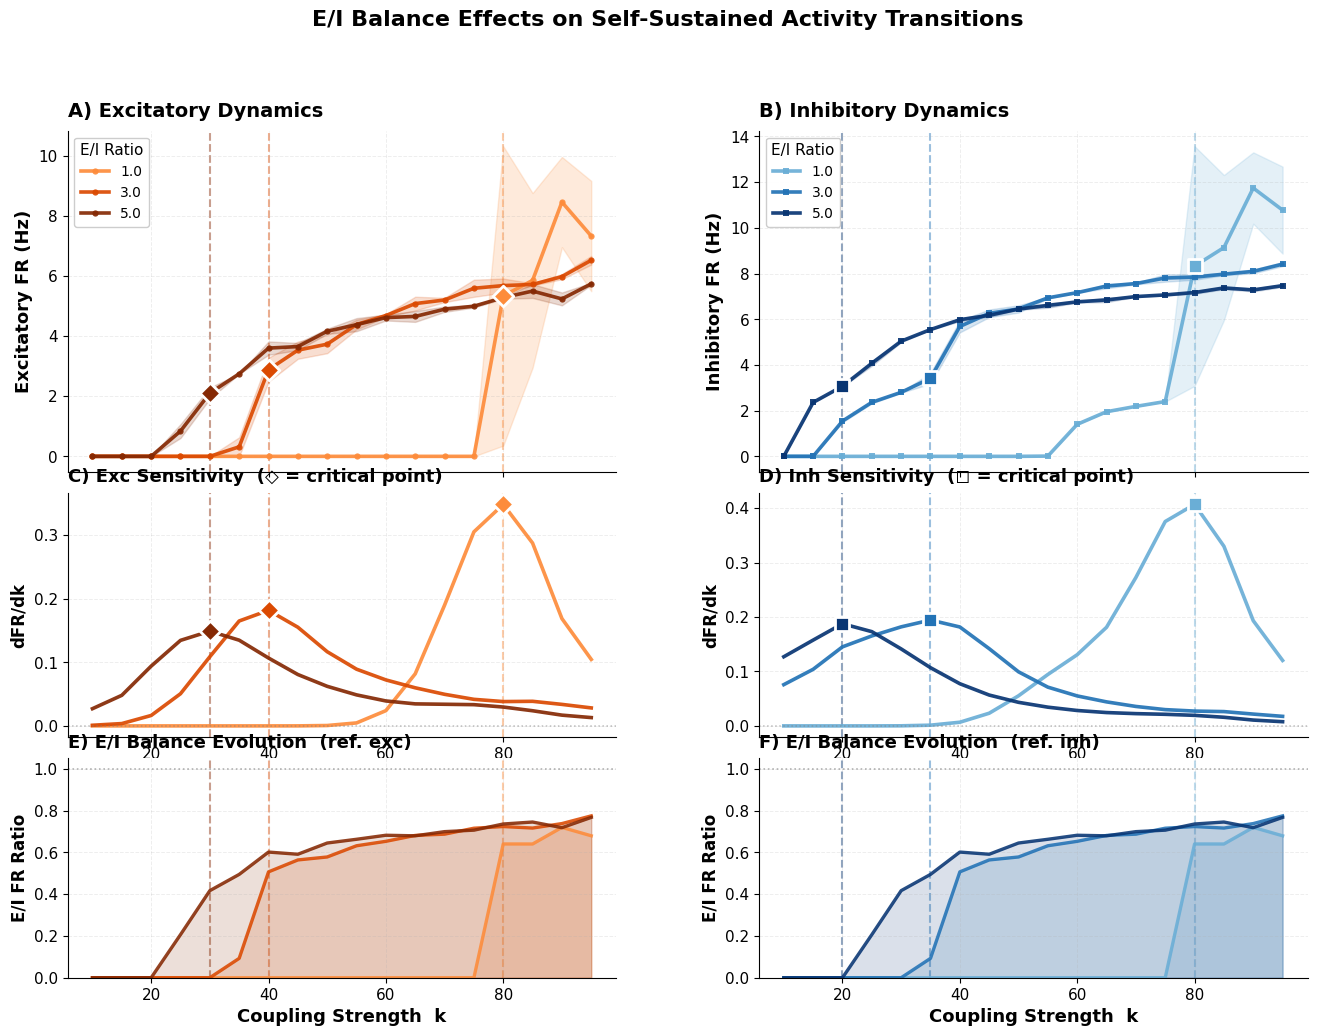


CRITICAL POINTS SUMMARY
 ratio  k_c_exc  k_c_inh  sens_exc  sens_inh
  1.00    80.00    80.00      0.35      0.41
  3.00    40.00    35.00      0.18      0.19
  5.00    30.00    20.00      0.15      0.19


In [36]:
#=============================================================================
# VISUALIZACIÓN: 2 COLUMNAS (EXC | INH)
# =============================================================================

critical_data = []

# Layout: 3 filas × 2 columnas
fig = plt.figure(figsize=(16, 11))
gs = fig.add_gridspec(3, 2, height_ratios=[1.4, 1.0, 0.9], 
                      hspace=0.08, wspace=0.26)

ax_exc = fig.add_subplot(gs[0, 0])
ax_inh = fig.add_subplot(gs[0, 1])
ax_grad_exc = fig.add_subplot(gs[1, 0], sharex=ax_exc)
ax_grad_inh = fig.add_subplot(gs[1, 1], sharex=ax_inh)
ax_ratio_exc = fig.add_subplot(gs[2, 0], sharex=ax_exc)
ax_ratio_inh = fig.add_subplot(gs[2, 1], sharex=ax_inh)

# Colores distinguibles
colors_exc = plt.cm.Oranges(np.linspace(0.50, 0.98, len(EI_RATIOS)))
colors_inh = plt.cm.Blues(np.linspace(0.50, 0.98, len(EI_RATIOS)))

for idx, ratio in enumerate(EI_RATIOS):
    grouped = results_global[ratio]
    k_vals = sorted(grouped.keys())
    
    # Calcular FR por tipo
    fr_exc_means, fr_exc_stds = [], []
    fr_inh_means, fr_inh_stds = [], []
    
    for k in k_vals:
        fr_exc_trials, fr_inh_trials = [], []
        
        for trial in range(N_TRIALS):
            results_dict = {'baseline': grouped[k][trial]}
            fr_steady = compute_steady_state_fr_by_type(
                results_dict, start_ms=1500, duration_ms=1500
            )
            fr_exc_trials.append(fr_steady['baseline']['fr_exc'])
            fr_inh_trials.append(fr_steady['baseline']['fr_inh'])
        
        fr_exc_means.append(np.mean(fr_exc_trials))
        fr_exc_stds.append(np.std(fr_exc_trials))
        fr_inh_means.append(np.mean(fr_inh_trials))
        fr_inh_stds.append(np.std(fr_inh_trials))
    
    # Suavizar y calcular gradientes
    fr_exc_smooth = gaussian_filter1d(fr_exc_means, sigma=1.5)
    fr_inh_smooth = gaussian_filter1d(fr_inh_means, sigma=1.5)
    grad_exc = np.gradient(fr_exc_smooth, k_vals)
    grad_inh = np.gradient(fr_inh_smooth, k_vals)
    
    # Ratio E/I instantáneo (evitar división por cero)
    ratio_ei = np.array([e/i if i > 0.1 else 0 for e, i in zip(fr_exc_means, fr_inh_means)])
    
    # Puntos críticos
    kc_exc_idx = np.argmax(grad_exc)
    kc_inh_idx = np.argmax(grad_inh)
    
    critical_data.append({
        'ratio': ratio,
        'k_c_exc': k_vals[kc_exc_idx],
        'k_c_inh': k_vals[kc_inh_idx],
        'sens_exc': grad_exc[kc_exc_idx],
        'sens_inh': grad_inh[kc_inh_idx]
    })
    
    # === PANEL EXCITATORIO ===
    ax_exc.plot(k_vals, fr_exc_means, 'o-', color=colors_exc[idx],
                linewidth=2.6, markersize=4.5, alpha=0.92, 
                label=f'{ratio:.1f}', markeredgewidth=0)
    ax_exc.fill_between(k_vals, 
                        np.array(fr_exc_means) - np.array(fr_exc_stds),
                        np.array(fr_exc_means) + np.array(fr_exc_stds),
                        alpha=0.18, color=colors_exc[idx])
    ax_exc.axvline(k_vals[kc_exc_idx], color=colors_exc[idx], 
                   linestyle='--', linewidth=1.5, alpha=0.45, zorder=1)
    ax_exc.scatter([k_vals[kc_exc_idx]], [fr_exc_means[kc_exc_idx]], 
                   s=110, color=colors_exc[idx], edgecolor='white', 
                   linewidth=2, zorder=10, marker='D')
    
    # === PANEL INHIBITORIO ===
    ax_inh.plot(k_vals, fr_inh_means, 's-', color=colors_inh[idx],
                linewidth=2.6, markersize=4.5, alpha=0.92, 
                label=f'{ratio:.1f}', markeredgewidth=0)
    ax_inh.fill_between(k_vals,
                        np.array(fr_inh_means) - np.array(fr_inh_stds),
                        np.array(fr_inh_means) + np.array(fr_inh_stds),
                        alpha=0.18, color=colors_inh[idx])
    ax_inh.axvline(k_vals[kc_inh_idx], color=colors_inh[idx],
                   linestyle='--', linewidth=1.5, alpha=0.45, zorder=1)
    ax_inh.scatter([k_vals[kc_inh_idx]], [fr_inh_means[kc_inh_idx]],
                   s=110, color=colors_inh[idx], edgecolor='white',
                   linewidth=2, zorder=10, marker='s')
    
    # === GRADIENTES ===
    ax_grad_exc.plot(k_vals, grad_exc, '-', color=colors_exc[idx], 
                     linewidth=2.6, alpha=0.92)
    ax_grad_exc.axvline(k_vals[kc_exc_idx], color=colors_exc[idx], 
                        linestyle='--', linewidth=1.5, alpha=0.45, zorder=1)
    ax_grad_exc.scatter([k_vals[kc_exc_idx]], [grad_exc[kc_exc_idx]], 
                        s=110, color=colors_exc[idx], edgecolor='white', 
                        linewidth=2, zorder=10, marker='D')
    
    ax_grad_inh.plot(k_vals, grad_inh, '-', color=colors_inh[idx],
                     linewidth=2.6, alpha=0.92)
    ax_grad_inh.axvline(k_vals[kc_inh_idx], color=colors_inh[idx],
                        linestyle='--', linewidth=1.5, alpha=0.45, zorder=1)
    ax_grad_inh.scatter([k_vals[kc_inh_idx]], [grad_inh[kc_inh_idx]],
                        s=110, color=colors_inh[idx], edgecolor='white',
                        linewidth=2, zorder=10, marker='s')
    
    # === RATIO E/I ===
    ax_ratio_exc.plot(k_vals, ratio_ei, '-', color=colors_exc[idx],
                      linewidth=2.4, alpha=0.88)
    ax_ratio_exc.fill_between(k_vals, ratio_ei, alpha=0.15, color=colors_exc[idx])
    ax_ratio_exc.axvline(k_vals[kc_exc_idx], color=colors_exc[idx],
                         linestyle='--', linewidth=1.5, alpha=0.45, zorder=1)
    
    # Mismo ratio E/I en panel inh (para comparación)
    ax_ratio_inh.plot(k_vals, ratio_ei, '-', color=colors_inh[idx],
                      linewidth=2.4, alpha=0.88)
    ax_ratio_inh.fill_between(k_vals, ratio_ei, alpha=0.15, color=colors_inh[idx])
    ax_ratio_inh.axvline(k_vals[kc_inh_idx], color=colors_inh[idx],
                         linestyle='--', linewidth=1.5, alpha=0.45, zorder=1)

# =============================================================================
# STYLING
# =============================================================================

# Panel Exc: FR
ax_exc.set_ylabel('Excitatory FR (Hz)', fontsize=13, fontweight='600')
ax_exc.legend(title='E/I Ratio', ncol=1, fontsize=10, framealpha=0.98, 
              loc='upper left', title_fontsize=11)
ax_exc.grid(alpha=0.22, linestyle='--', linewidth=0.7)
ax_exc.set_title('A) Excitatory Dynamics', 
                 fontsize=14, fontweight='700', pad=10, loc='left')
ax_exc.tick_params(labelbottom=False, labelsize=11)
ax_exc.spines['top'].set_visible(False)
ax_exc.spines['right'].set_visible(False)

# Panel Inh: FR
ax_inh.set_ylabel('Inhibitory FR (Hz)', fontsize=13, fontweight='600')
ax_inh.legend(title='E/I Ratio', ncol=1, fontsize=10, framealpha=0.98,
              loc='upper left', title_fontsize=11)
ax_inh.grid(alpha=0.22, linestyle='--', linewidth=0.7)
ax_inh.set_title('B) Inhibitory Dynamics', 
                 fontsize=14, fontweight='700', pad=10, loc='left')
ax_inh.tick_params(labelbottom=False, labelsize=11)
ax_inh.spines['top'].set_visible(False)
ax_inh.spines['right'].set_visible(False)

# Panel Exc: Gradiente
ax_grad_exc.axhline(0, color='gray', linestyle=':', linewidth=1.1, alpha=0.5)
ax_grad_exc.set_xlabel('Coupling Strength  k', fontsize=13, fontweight='600')
ax_grad_exc.set_ylabel('dFR/dk', fontsize=12, fontweight='600')
ax_grad_exc.grid(alpha=0.22, linestyle='--', linewidth=0.7)
ax_grad_exc.set_title('C) Exc Sensitivity  (◇ = critical point)', 
                      fontsize=13, fontweight='700', pad=8, loc='left')
ax_grad_exc.tick_params(labelsize=11)
ax_grad_exc.spines['top'].set_visible(False)
ax_grad_exc.spines['right'].set_visible(False)

# Panel Inh: Gradiente
ax_grad_inh.axhline(0, color='gray', linestyle=':', linewidth=1.1, alpha=0.5)
ax_grad_inh.set_xlabel('Coupling Strength  k', fontsize=13, fontweight='600')
ax_grad_inh.set_ylabel('dFR/dk', fontsize=12, fontweight='600')
ax_grad_inh.grid(alpha=0.22, linestyle='--', linewidth=0.7)
ax_grad_inh.set_title('D) Inh Sensitivity  (◻ = critical point)', 
                      fontsize=13, fontweight='700', pad=8, loc='left')
ax_grad_inh.tick_params(labelsize=11)
ax_grad_inh.spines['top'].set_visible(False)
ax_grad_inh.spines['right'].set_visible(False)

# Panel Exc: Ratio E/I
ax_ratio_exc.axhline(1, color='gray', linestyle=':', linewidth=1.2, alpha=0.6)
ax_ratio_exc.set_xlabel('Coupling Strength  k', fontsize=13, fontweight='600')
ax_ratio_exc.set_ylabel('E/I FR Ratio', fontsize=12, fontweight='600')
ax_ratio_exc.grid(alpha=0.22, linestyle='--', linewidth=0.7)
ax_ratio_exc.set_title('E) E/I Balance Evolution  (ref. exc)', 
                       fontsize=13, fontweight='700', pad=8, loc='left')
ax_ratio_exc.tick_params(labelsize=11)
ax_ratio_exc.spines['top'].set_visible(False)
ax_ratio_exc.spines['right'].set_visible(False)
ax_ratio_exc.set_ylim([0, None])

# Panel Inh: Ratio E/I
ax_ratio_inh.axhline(1, color='gray', linestyle=':', linewidth=1.2, alpha=0.6)
ax_ratio_inh.set_xlabel('Coupling Strength  k', fontsize=13, fontweight='600')
ax_ratio_inh.set_ylabel('E/I FR Ratio', fontsize=12, fontweight='600')
ax_ratio_inh.grid(alpha=0.22, linestyle='--', linewidth=0.7)
ax_ratio_inh.set_title('F) E/I Balance Evolution  (ref. inh)', 
                       fontsize=13, fontweight='700', pad=8, loc='left')
ax_ratio_inh.tick_params(labelsize=11)
ax_ratio_inh.spines['top'].set_visible(False)
ax_ratio_inh.spines['right'].set_visible(False)
ax_ratio_inh.set_ylim([0, None])

# Título global
plt.suptitle('E/I Balance Effects on Self-Sustained Activity Transitions', 
             fontsize=16, fontweight='800', y=0.99)

plt.savefig('./ei_ratio_separated.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Tabla resumen
crit_df = pd.DataFrame(critical_data)
print("\n" + "="*60)
print("CRITICAL POINTS SUMMARY")
print("="*60)
print(crit_df.to_string(index=False, float_format='%.2f'))
print("="*60)


In [ ]:
# =============================================================================
# VISUALIZACIÓN: 2 COLUMNAS (EXC | INH)
# =============================================================================

critical_data = []

# Layout: Exc (izq) | Inh (der), cada uno con FR + derivada
fig = plt.figure(figsize=(16, 9))
gs = fig.add_gridspec(2, 2, height_ratios=[1.5, 1.1], 
                      hspace=0.08, wspace=0.26)

ax_exc = fig.add_subplot(gs[0, 0])
ax_inh = fig.add_subplot(gs[0, 1])
ax_grad_exc = fig.add_subplot(gs[1, 0], sharex=ax_exc)
ax_grad_inh = fig.add_subplot(gs[1, 1], sharex=ax_inh)

# Colores distinguibles
colors_exc = plt.cm.Oranges(np.linspace(0.50, 0.98, len(EI_RATIOS)))
colors_inh = plt.cm.Blues(np.linspace(0.50, 0.98, len(EI_RATIOS)))

for idx, ratio in enumerate(EI_RATIOS):
    grouped = results_global[ratio]
    k_vals = sorted(grouped.keys())
    
    # Calcular FR por tipo
    fr_exc_means, fr_exc_stds = [], []
    fr_inh_means, fr_inh_stds = [], []
    
    for k in k_vals:
        fr_exc_trials, fr_inh_trials = [], []
        
        for trial in range(N_TRIALS):
            results_dict = {'baseline': grouped[k][trial]}
            fr_steady = compute_steady_state_fr_by_type(
                results_dict, start_ms=1500, duration_ms=1500
            )
            fr_exc_trials.append(fr_steady['baseline']['fr_exc'])
            fr_inh_trials.append(fr_steady['baseline']['fr_inh'])
        
        fr_exc_means.append(np.mean(fr_exc_trials))
        fr_exc_stds.append(np.std(fr_exc_trials))
        fr_inh_means.append(np.mean(fr_inh_trials))
        fr_inh_stds.append(np.std(fr_inh_trials))
    
    # Suavizar y calcular gradientes
    fr_exc_smooth = gaussian_filter1d(fr_exc_means, sigma=1.5)
    fr_inh_smooth = gaussian_filter1d(fr_inh_means, sigma=1.5)
    grad_exc = np.gradient(fr_exc_smooth, k_vals)
    grad_inh = np.gradient(fr_inh_smooth, k_vals)
    
    # Puntos críticos
    kc_exc_idx = np.argmax(grad_exc)
    kc_inh_idx = np.argmax(grad_inh)
    
    critical_data.append({
        'ratio': ratio,
        'k_c_exc': k_vals[kc_exc_idx],
        'k_c_inh': k_vals[kc_inh_idx],
        'sens_exc': grad_exc[kc_exc_idx],
        'sens_inh': grad_inh[kc_inh_idx]
    })
    
    # === PANEL EXCITATORIO ===
    ax_exc.plot(k_vals, fr_exc_means, 'o-', color=colors_exc[idx],
                linewidth=2.6, markersize=4.5, alpha=0.92, 
                label=f'{ratio:.1f}', markeredgewidth=0)
    ax_exc.fill_between(k_vals, 
                        np.array(fr_exc_means) - np.array(fr_exc_stds),
                        np.array(fr_exc_means) + np.array(fr_exc_stds),
                        alpha=0.18, color=colors_exc[idx])
    ax_exc.axvline(k_vals[kc_exc_idx], color=colors_exc[idx], 
                   linestyle='--', linewidth=1.5, alpha=0.45, zorder=1)
    ax_exc.scatter([k_vals[kc_exc_idx]], [fr_exc_means[kc_exc_idx]], 
                   s=110, color=colors_exc[idx], edgecolor='white', 
                   linewidth=2, zorder=10, marker='D')
    
    # === PANEL INHIBITORIO ===
    ax_inh.plot(k_vals, fr_inh_means, 's-', color=colors_inh[idx],
                linewidth=2.6, markersize=4.5, alpha=0.92, 
                label=f'{ratio:.1f}', markeredgewidth=0)
    ax_inh.fill_between(k_vals,
                        np.array(fr_inh_means) - np.array(fr_inh_stds),
                        np.array(fr_inh_means) + np.array(fr_inh_stds),
                        alpha=0.18, color=colors_inh[idx])
    ax_inh.axvline(k_vals[kc_inh_idx], color=colors_inh[idx],
                   linestyle='--', linewidth=1.5, alpha=0.45, zorder=1)
    ax_inh.scatter([k_vals[kc_inh_idx]], [fr_inh_means[kc_inh_idx]],
                   s=110, color=colors_inh[idx], edgecolor='white',
                   linewidth=2, zorder=10, marker='s')
    
    # === GRADIENTES ===
    ax_grad_exc.plot(k_vals, grad_exc, '-', color=colors_exc[idx], 
                     linewidth=2.6, alpha=0.92)
    ax_grad_exc.axvline(k_vals[kc_exc_idx], color=colors_exc[idx], 
                        linestyle='--', linewidth=1.5, alpha=0.45, zorder=1)
    ax_grad_exc.scatter([k_vals[kc_exc_idx]], [grad_exc[kc_exc_idx]], 
                        s=110, color=colors_exc[idx], edgecolor='white', 
                        linewidth=2, zorder=10, marker='D')
    
    ax_grad_inh.plot(k_vals, grad_inh, '-', color=colors_inh[idx],
                     linewidth=2.6, alpha=0.92)
    ax_grad_inh.axvline(k_vals[kc_inh_idx], color=colors_inh[idx],
                        linestyle='--', linewidth=1.5, alpha=0.45, zorder=1)
    ax_grad_inh.scatter([k_vals[kc_inh_idx]], [grad_inh[kc_inh_idx]],
                        s=110, color=colors_inh[idx], edgecolor='white',
                        linewidth=2, zorder=10, marker='s')

# =============================================================================
# STYLING
# =============================================================================

# Panel Exc: FR
ax_exc.set_ylabel('Excitatory FR (Hz)', fontsize=13, fontweight='600')
ax_exc.legend(title='E/I Ratio', ncol=1, fontsize=10, framealpha=0.98, 
              loc='upper left', title_fontsize=11)
ax_exc.grid(alpha=0.22, linestyle='--', linewidth=0.7)
ax_exc.set_title('A) Excitatory Dynamics', 
                 fontsize=14, fontweight='700', pad=10, loc='left')
ax_exc.tick_params(labelbottom=False, labelsize=11)
ax_exc.spines['top'].set_visible(False)
ax_exc.spines['right'].set_visible(False)

# Panel Inh: FR
ax_inh.set_ylabel('Inhibitory FR (Hz)', fontsize=13, fontweight='600')
ax_inh.legend(title='E/I Ratio', ncol=1, fontsize=10, framealpha=0.98,
              loc='upper left', title_fontsize=11)
ax_inh.grid(alpha=0.22, linestyle='--', linewidth=0.7)
ax_inh.set_title('B) Inhibitory Dynamics', 
                 fontsize=14, fontweight='700', pad=10, loc='left')
ax_inh.tick_params(labelbottom=False, labelsize=11)
ax_inh.spines['top'].set_visible(False)
ax_inh.spines['right'].set_visible(False)

# Panel Exc: Gradiente
ax_grad_exc.axhline(0, color='gray', linestyle=':', linewidth=1.1, alpha=0.5)
ax_grad_exc.set_xlabel('Coupling Strength  k', fontsize=13, fontweight='600')
ax_grad_exc.set_ylabel('dFR/dk', fontsize=12, fontweight='600')
ax_grad_exc.grid(alpha=0.22, linestyle='--', linewidth=0.7)
ax_grad_exc.set_title('C) Exc Sensitivity  (◇ = critical point)', 
                      fontsize=13, fontweight='700', pad=8, loc='left')
ax_grad_exc.tick_params(labelsize=11)
ax_grad_exc.spines['top'].set_visible(False)
ax_grad_exc.spines['right'].set_visible(False)

# Panel Inh: Gradiente
ax_grad_inh.axhline(0, color='gray', linestyle=':', linewidth=1.1, alpha=0.5)
ax_grad_inh.set_xlabel('Coupling Strength  k', fontsize=13, fontweight='600')
ax_grad_inh.set_ylabel('dFR/dk', fontsize=12, fontweight='600')
ax_grad_inh.grid(alpha=0.22, linestyle='--', linewidth=0.7)
ax_grad_inh.set_title('D) Inh Sensitivity  (◻ = critical point)', 
                      fontsize=13, fontweight='700', pad=8, loc='left')
ax_grad_inh.tick_params(labelsize=11)
ax_grad_inh.spines['top'].set_visible(False)
ax_grad_inh.spines['right'].set_visible(False)

# Título global
plt.suptitle('E/I Balance Effects on Self-Sustained Activity Transitions', 
             fontsize=16, fontweight='800', y=0.99)

plt.savefig('/mnt/user-data/outputs/ei_ratio_separated.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Tabla resumen
crit_df = pd.DataFrame(critical_data)
print("\n" + "="*60)
print("CRITICAL POINTS SUMMARY")
print("="*60)
print(crit_df.to_string(index=False, float_format='%.2f'))
print("="*60)

In [29]:
crit_df

,ratio,k_c,sensitivity,variance,k_c_exc,k_c_inh
0,1.0,82.0,0.829722,4.622907,82.0,82.0
1,2.0,55.0,0.656326,2.225326,55.0,55.0
2,3.0,39.0,0.547234,0.830646,39.0,39.0
3,4.0,30.0,0.410992,0.500787,30.0,15.0
4,5.0,25.0,0.342762,0.344312,25.0,12.0


WARNING    /tmp/ipykernel_60831/2574576089.py:183: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]


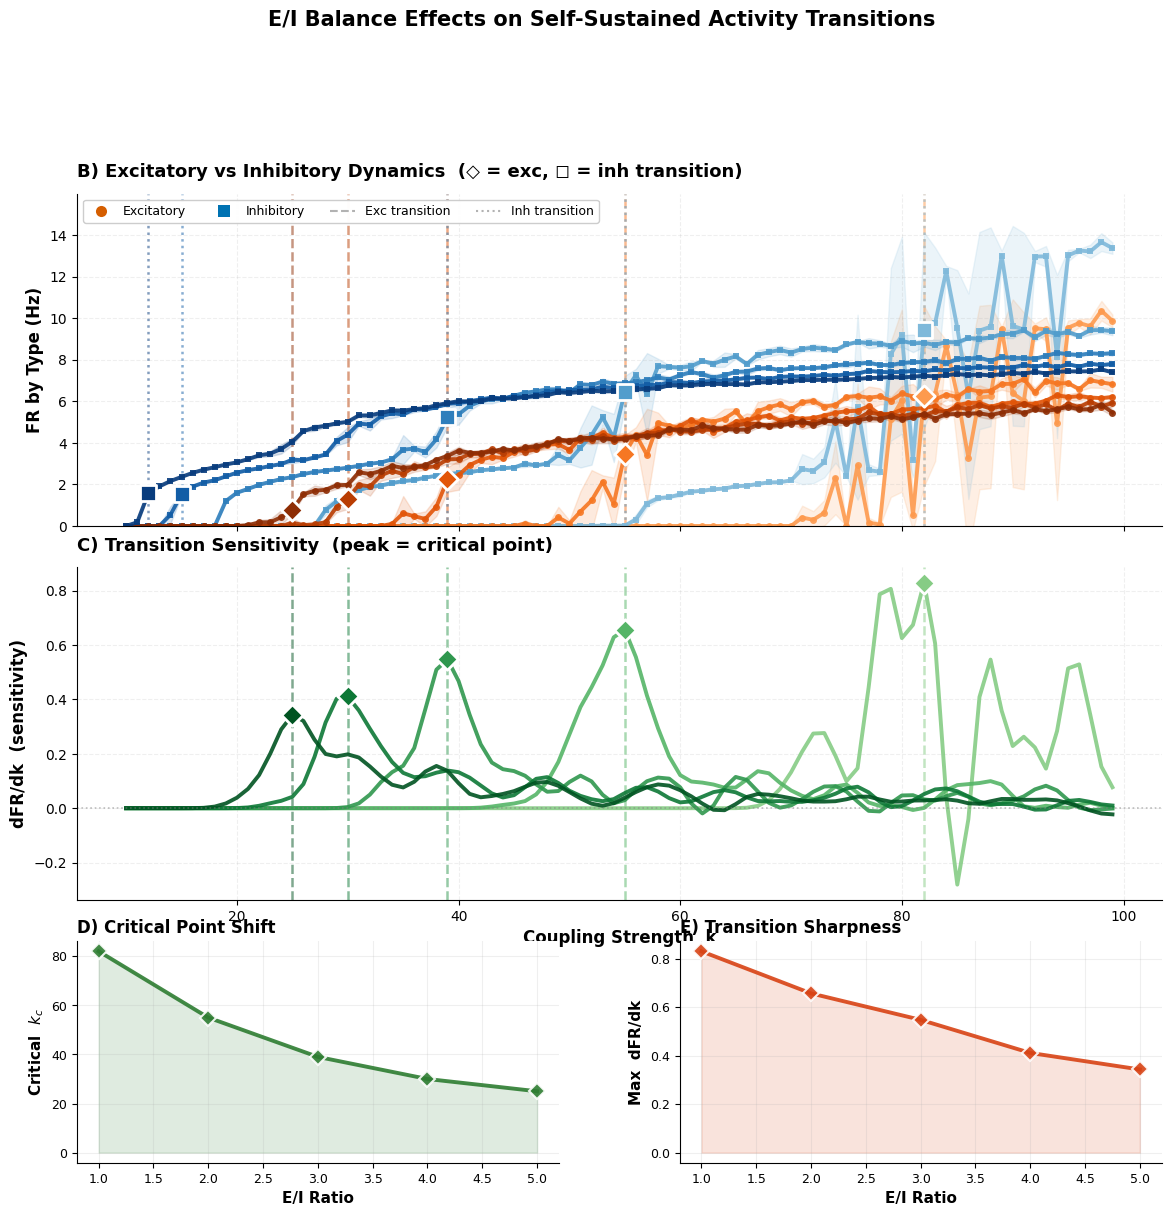


Critical Points Summary:
 ratio  k_c  sensitivity  variance  k_c_exc  k_c_inh
   1.0 82.0     0.829722  4.622907     82.0     82.0
   2.0 55.0     0.656326  2.225326     55.0     55.0
   3.0 39.0     0.547234  0.830646     39.0     39.0
   4.0 30.0     0.410992  0.500787     30.0     15.0
   5.0 25.0     0.342762  0.344312     25.0     12.0


In [25]:


# =============================================================================
# ANÁLISIS Y VISUALIZACIÓN
# =============================================================================

critical_data = []

# Figura con 3 paneles alineados verticalmente + 2 resumen
fig = plt.figure(figsize=(14, 16))
gs = fig.add_gridspec(4, 2, height_ratios=[1.5, 1.5, 1, 1], 
                      hspace=0.15, wspace=0.25)

ax_fr_type = fig.add_subplot(gs[0, :])
ax_grad = fig.add_subplot(gs[1, :], sharex=ax_fr_type)
ax_kc = fig.add_subplot(gs[2, 0])
ax_sens = fig.add_subplot(gs[2, 1])

# Colores distinguibles
colors_exc = plt.cm.Oranges(np.linspace(0.45, 0.95, len(EI_RATIOS)))
colors_inh = plt.cm.Blues(np.linspace(0.45, 0.95, len(EI_RATIOS)))
colors_total = plt.cm.Greens(np.linspace(0.45, 0.95, len(EI_RATIOS)))

for idx, ratio in enumerate(EI_RATIOS):
    grouped = results_global[ratio]
    k_vals = sorted(grouped.keys())
    
    # Calcular FR total y por tipo
    fr_means, fr_stds = [], []
    fr_exc_means, fr_exc_stds = [], []
    fr_inh_means, fr_inh_stds = [], []
    
    for k in k_vals:
        fr_trials, fr_exc_trials, fr_inh_trials = [], [], []
        
        for trial in range(N_TRIALS):
            results_dict = {'baseline': grouped[k][trial]}
            
            # FR total (original)
            fr_steady = compute_steady_state_fr_by_type(
                results_dict, start_ms=1500, duration_ms=1500
            )
            
            fr_exc_trials.append(fr_steady['baseline']['fr_exc'])
            fr_inh_trials.append(fr_steady['baseline']['fr_inh'])
            fr_trials.append(fr_steady['baseline']['fr_exc'])  # Para gradiente
        
        fr_means.append(np.mean(fr_trials))
        fr_stds.append(np.std(fr_trials))
        fr_exc_means.append(np.mean(fr_exc_trials))
        fr_exc_stds.append(np.std(fr_exc_trials))
        fr_inh_means.append(np.mean(fr_inh_trials))
        fr_inh_stds.append(np.std(fr_inh_trials))
    
    # Panel 1: FR total con detección de transición mejorada
    fr_smooth = gaussian_filter1d(fr_means, sigma=1.5)
    fr_exc_smooth = gaussian_filter1d(fr_exc_means, sigma=1.5)
    fr_inh_smooth = gaussian_filter1d(fr_inh_means, sigma=1.5)
    
    grad = np.gradient(fr_smooth, k_vals)
    grad_exc = np.gradient(fr_exc_smooth, k_vals)
    grad_inh = np.gradient(fr_inh_smooth, k_vals)
    
    # Punto crítico: máxima pendiente en FR total
    kc_idx = np.argmax(grad)
    k_c = k_vals[kc_idx]
    
    # Almacenar datos
    critical_data.append({
        'ratio': ratio, 'k_c': k_c,
        'sensitivity': grad[kc_idx],
        'variance': np.max(fr_stds),
        'k_c_exc': k_vals[np.argmax(grad_exc)],
        'k_c_inh': k_vals[np.argmax(grad_inh)]
    })
    
    
    # Panel 2: FR por tipo con marcadores de transición
    kc_exc_idx = np.argmax(grad_exc)
    kc_inh_idx = np.argmax(grad_inh)
    
    # Curvas excitatorias
    ax_fr_type.plot(k_vals, fr_exc_means, 'o-', color=colors_exc[idx],
                    linewidth=2.8, markersize=5, alpha=0.9,
                    markerfacecolor=colors_exc[idx], markeredgewidth=0)
    ax_fr_type.fill_between(k_vals, 
                            np.array(fr_exc_means) - np.array(fr_exc_stds),
                            np.array(fr_exc_means) + np.array(fr_exc_stds),
                            alpha=0.15, color=colors_exc[idx])
    ax_fr_type.axvline(k_vals[kc_exc_idx], color=colors_exc[idx], 
                       linestyle='--', linewidth=1.8, alpha=0.5, zorder=1)
    ax_fr_type.scatter([k_vals[kc_exc_idx]], [fr_exc_means[kc_exc_idx]], 
                       s=120, color=colors_exc[idx], edgecolor='white', 
                       linewidth=2, zorder=10, marker='D')
    
    # Curvas inhibitorias
    ax_fr_type.plot(k_vals, fr_inh_means, 's-', color=colors_inh[idx],
                    linewidth=2.8, markersize=5, alpha=0.9,
                    markerfacecolor=colors_inh[idx], markeredgewidth=0)
    ax_fr_type.fill_between(k_vals,
                            np.array(fr_inh_means) - np.array(fr_inh_stds),
                            np.array(fr_inh_means) + np.array(fr_inh_stds),
                            alpha=0.15, color=colors_inh[idx])
    ax_fr_type.axvline(k_vals[kc_inh_idx], color=colors_inh[idx],
                       linestyle=':', linewidth=1.8, alpha=0.5, zorder=1)
    ax_fr_type.scatter([k_vals[kc_inh_idx]], [fr_inh_means[kc_inh_idx]],
                       s=120, color=colors_inh[idx], edgecolor='white',
                       linewidth=2, zorder=10, marker='s')
    
    # Panel 3: Gradiente con marcadores de transición
    ax_grad.plot(k_vals, grad, '-', color=colors_total[idx], 
                 linewidth=2.8, alpha=0.9)
    ax_grad.axvline(k_c, color=colors_total[idx], linestyle='--', 
                    linewidth=1.8, alpha=0.5, zorder=1)
    ax_grad.scatter([k_c], [grad[kc_idx]], s=120, color=colors_total[idx], 
                    edgecolor='white', linewidth=2, zorder=10, marker='D')

# Styling Panel 2: FR por tipo
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='none', marker='o', markersize=8, 
           markerfacecolor='#D55E00', label='Excitatory', markeredgewidth=0),
    Line2D([0], [0], color='none', marker='s', markersize=8,
           markerfacecolor='#0072B2', label='Inhibitory', markeredgewidth=0),
    Line2D([0], [0], color='gray', linestyle='--', linewidth=1.5,
           label='Exc transition', alpha=0.6),
    Line2D([0], [0], color='gray', linestyle=':', linewidth=1.5,
           label='Inh transition', alpha=0.6)
]
ax_fr_type.set_ylabel('FR by Type (Hz)', fontsize=12, fontweight='600')
ax_fr_type.legend(handles=legend_elements, ncol=4, fontsize=9, 
                  framealpha=0.98, loc='upper left')
ax_fr_type.grid(alpha=0.2, linestyle='--', linewidth=0.8)
ax_fr_type.set_title('B) Excitatory vs Inhibitory Dynamics  (◇ = exc, ◻ = inh transition)', 
                     fontsize=13, fontweight='700', pad=12, loc='left')
ax_fr_type.tick_params(labelbottom=False, labelsize=10)
ax_fr_type.spines['top'].set_visible(False)
ax_fr_type.spines['right'].set_visible(False)

# Styling Panel 3: Gradiente
ax_grad.axhline(0, color='gray', linestyle=':', linewidth=1.2, alpha=0.5)
ax_grad.set_xlabel('Coupling Strength  k', fontsize=12, fontweight='600')
ax_grad.set_ylabel('dFR/dk  (sensitivity)', fontsize=12, fontweight='600')
ax_grad.grid(alpha=0.2, linestyle='--', linewidth=0.8)
ax_grad.set_title('C) Transition Sensitivity  (peak = critical point)', 
                  fontsize=13, fontweight='700', pad=12, loc='left')
ax_grad.tick_params(labelsize=10)
ax_grad.spines['top'].set_visible(False)
ax_grad.spines['right'].set_visible(False)

# Alinear límites y-axis entre paneles relacionados
fr_max = ax_fr_type.get_ylim()[1]
ax_fr_type.set_ylim([0, fr_max * 1.05])

# Panels 4-5: Resumen
crit_df = pd.DataFrame(critical_data)

ax_kc.plot(crit_df['ratio'], crit_df['k_c'], 'D-', 
           color='#2E7D32', linewidth=2.8, markersize=8, 
           markeredgecolor='white', markeredgewidth=1.5, alpha=0.9)
ax_kc.fill_between(crit_df['ratio'], crit_df['k_c'], alpha=0.15, color='#2E7D32')
ax_kc.set_xlabel('E/I Ratio', fontsize=11, fontweight='600')
ax_kc.set_ylabel('Critical  $k_c$', fontsize=11, fontweight='600')
ax_kc.set_title('D) Critical Point Shift', fontsize=12, fontweight='700', loc='left')
ax_kc.grid(alpha=0.2, linewidth=0.8)
ax_kc.tick_params(labelsize=9)
ax_kc.spines['top'].set_visible(False)
ax_kc.spines['right'].set_visible(False)

ax_sens.plot(crit_df['ratio'], crit_df['sensitivity'], 'D-',
             color='#D84315', linewidth=2.8, markersize=8,
             markeredgecolor='white', markeredgewidth=1.5, alpha=0.9)
ax_sens.fill_between(crit_df['ratio'], crit_df['sensitivity'], 
                     alpha=0.15, color='#D84315')
ax_sens.set_xlabel('E/I Ratio', fontsize=11, fontweight='600')
ax_sens.set_ylabel('Max  dFR/dk', fontsize=11, fontweight='600')
ax_sens.set_title('E) Transition Sharpness', fontsize=12, fontweight='700', loc='left')
ax_sens.grid(alpha=0.2, linewidth=0.8)
ax_sens.tick_params(labelsize=9)
ax_sens.spines['top'].set_visible(False)
ax_sens.spines['right'].set_visible(False)

plt.suptitle('E/I Balance Effects on Self-Sustained Activity Transitions', 
             fontsize=15, fontweight='800', y=0.995)
plt.tight_layout()

plt.savefig('ei_ratio_by_type.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("\nCritical Points Summary:")
print(crit_df.to_string(index=False))

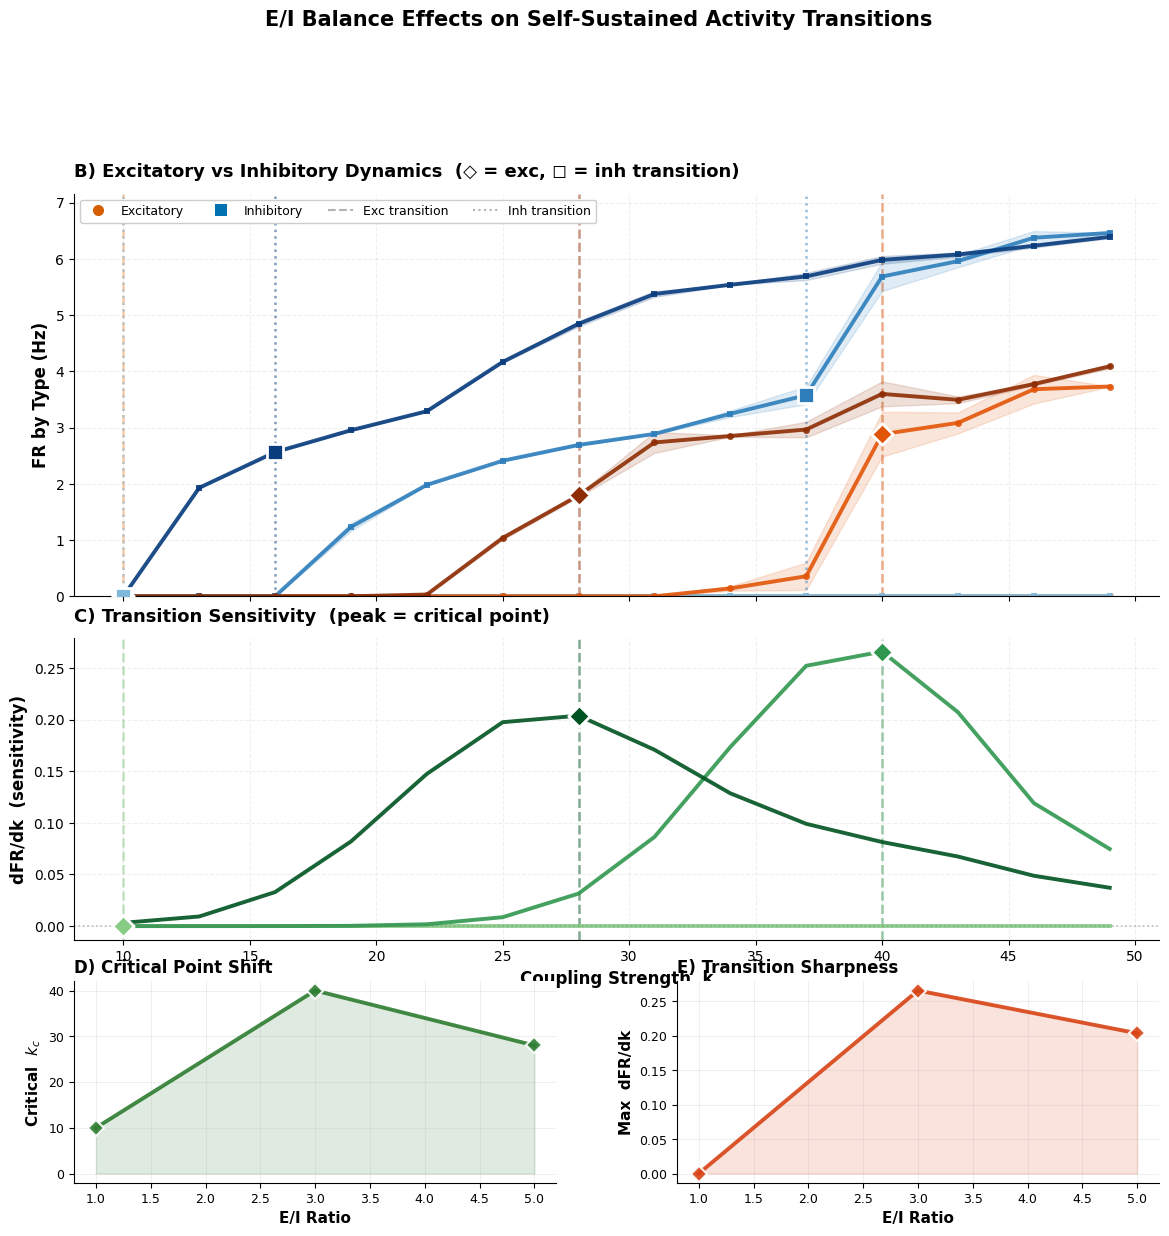


Critical Points Summary:
 ratio  k_c  sensitivity  variance  k_c_exc  k_c_inh
   1.0 10.0     0.000000  0.000000     10.0     10.0
   3.0 40.0     0.265806  0.398333     40.0     37.0
   5.0 28.0     0.203745  0.221667     28.0     16.0


In [23]:


# =============================================================================
# ANÁLISIS Y VISUALIZACIÓN
# =============================================================================

critical_data = []

# Figura con 3 paneles alineados verticalmente + 2 resumen
fig = plt.figure(figsize=(14, 16))
gs = fig.add_gridspec(4, 2, height_ratios=[1.5, 1.5, 1, 1], 
                      hspace=0.15, wspace=0.25)

ax_fr_type = fig.add_subplot(gs[0, :])
ax_grad = fig.add_subplot(gs[1, :], sharex=ax_fr_type)
ax_kc = fig.add_subplot(gs[2, 0])
ax_sens = fig.add_subplot(gs[2, 1])

# Colores distinguibles
colors_exc = plt.cm.Oranges(np.linspace(0.45, 0.95, len(EI_RATIOS)))
colors_inh = plt.cm.Blues(np.linspace(0.45, 0.95, len(EI_RATIOS)))
colors_total = plt.cm.Greens(np.linspace(0.45, 0.95, len(EI_RATIOS)))

for idx, ratio in enumerate(EI_RATIOS):
    grouped = results_global[ratio]
    k_vals = sorted(grouped.keys())
    
    # Calcular FR total y por tipo
    fr_means, fr_stds = [], []
    fr_exc_means, fr_exc_stds = [], []
    fr_inh_means, fr_inh_stds = [], []
    
    for k in k_vals:
        fr_trials, fr_exc_trials, fr_inh_trials = [], [], []
        
        for trial in range(N_TRIALS):
            results_dict = {'baseline': grouped[k][trial]}
            
            # FR total (original)
            fr_steady = compute_steady_state_fr_by_type(
                results_dict, start_ms=1500, duration_ms=1500
            )
            
            fr_exc_trials.append(fr_steady['baseline']['fr_exc'])
            fr_inh_trials.append(fr_steady['baseline']['fr_inh'])
            fr_trials.append(fr_steady['baseline']['fr_exc'])  # Para gradiente
        
        fr_means.append(np.mean(fr_trials))
        fr_stds.append(np.std(fr_trials))
        fr_exc_means.append(np.mean(fr_exc_trials))
        fr_exc_stds.append(np.std(fr_exc_trials))
        fr_inh_means.append(np.mean(fr_inh_trials))
        fr_inh_stds.append(np.std(fr_inh_trials))
    
    # Panel 1: FR total con detección de transición mejorada
    fr_smooth = gaussian_filter1d(fr_means, sigma=1.5)
    fr_exc_smooth = gaussian_filter1d(fr_exc_means, sigma=1.5)
    fr_inh_smooth = gaussian_filter1d(fr_inh_means, sigma=1.5)
    
    grad = np.gradient(fr_smooth, k_vals)
    grad_exc = np.gradient(fr_exc_smooth, k_vals)
    grad_inh = np.gradient(fr_inh_smooth, k_vals)
    
    # Punto crítico: máxima pendiente en FR total
    kc_idx = np.argmax(grad)
    k_c = k_vals[kc_idx]
    
    # Almacenar datos
    critical_data.append({
        'ratio': ratio, 'k_c': k_c,
        'sensitivity': grad[kc_idx],
        'variance': np.max(fr_stds),
        'k_c_exc': k_vals[np.argmax(grad_exc)],
        'k_c_inh': k_vals[np.argmax(grad_inh)]
    })
    
    
    # Panel 2: FR por tipo con marcadores de transición
    kc_exc_idx = np.argmax(grad_exc)
    kc_inh_idx = np.argmax(grad_inh)
    
    # Curvas excitatorias
    ax_fr_type.plot(k_vals, fr_exc_means, 'o-', color=colors_exc[idx],
                    linewidth=2.8, markersize=5, alpha=0.9,
                    markerfacecolor=colors_exc[idx], markeredgewidth=0)
    ax_fr_type.fill_between(k_vals, 
                            np.array(fr_exc_means) - np.array(fr_exc_stds),
                            np.array(fr_exc_means) + np.array(fr_exc_stds),
                            alpha=0.15, color=colors_exc[idx])
    ax_fr_type.axvline(k_vals[kc_exc_idx], color=colors_exc[idx], 
                       linestyle='--', linewidth=1.8, alpha=0.5, zorder=1)
    ax_fr_type.scatter([k_vals[kc_exc_idx]], [fr_exc_means[kc_exc_idx]], 
                       s=120, color=colors_exc[idx], edgecolor='white', 
                       linewidth=2, zorder=10, marker='D')
    
    # Curvas inhibitorias
    ax_fr_type.plot(k_vals, fr_inh_means, 's-', color=colors_inh[idx],
                    linewidth=2.8, markersize=5, alpha=0.9,
                    markerfacecolor=colors_inh[idx], markeredgewidth=0)
    ax_fr_type.fill_between(k_vals,
                            np.array(fr_inh_means) - np.array(fr_inh_stds),
                            np.array(fr_inh_means) + np.array(fr_inh_stds),
                            alpha=0.15, color=colors_inh[idx])
    ax_fr_type.axvline(k_vals[kc_inh_idx], color=colors_inh[idx],
                       linestyle=':', linewidth=1.8, alpha=0.5, zorder=1)
    ax_fr_type.scatter([k_vals[kc_inh_idx]], [fr_inh_means[kc_inh_idx]],
                       s=120, color=colors_inh[idx], edgecolor='white',
                       linewidth=2, zorder=10, marker='s')
    
    # Panel 3: Gradiente con marcadores de transición
    ax_grad.plot(k_vals, grad, '-', color=colors_total[idx], 
                 linewidth=2.8, alpha=0.9)
    ax_grad.axvline(k_c, color=colors_total[idx], linestyle='--', 
                    linewidth=1.8, alpha=0.5, zorder=1)
    ax_grad.scatter([k_c], [grad[kc_idx]], s=120, color=colors_total[idx], 
                    edgecolor='white', linewidth=2, zorder=10, marker='D')

# Styling Panel 2: FR por tipo
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='none', marker='o', markersize=8, 
           markerfacecolor='#D55E00', label='Excitatory', markeredgewidth=0),
    Line2D([0], [0], color='none', marker='s', markersize=8,
           markerfacecolor='#0072B2', label='Inhibitory', markeredgewidth=0),
    Line2D([0], [0], color='gray', linestyle='--', linewidth=1.5,
           label='Exc transition', alpha=0.6),
    Line2D([0], [0], color='gray', linestyle=':', linewidth=1.5,
           label='Inh transition', alpha=0.6)
]
ax_fr_type.set_ylabel('FR by Type (Hz)', fontsize=12, fontweight='600')
ax_fr_type.legend(handles=legend_elements, ncol=4, fontsize=9, 
                  framealpha=0.98, loc='upper left')
ax_fr_type.grid(alpha=0.2, linestyle='--', linewidth=0.8)
ax_fr_type.set_title('B) Excitatory vs Inhibitory Dynamics  (◇ = exc, ◻ = inh transition)', 
                     fontsize=13, fontweight='700', pad=12, loc='left')
ax_fr_type.tick_params(labelbottom=False, labelsize=10)
ax_fr_type.spines['top'].set_visible(False)
ax_fr_type.spines['right'].set_visible(False)

# Styling Panel 3: Gradiente
ax_grad.axhline(0, color='gray', linestyle=':', linewidth=1.2, alpha=0.5)
ax_grad.set_xlabel('Coupling Strength  k', fontsize=12, fontweight='600')
ax_grad.set_ylabel('dFR/dk  (sensitivity)', fontsize=12, fontweight='600')
ax_grad.grid(alpha=0.2, linestyle='--', linewidth=0.8)
ax_grad.set_title('C) Transition Sensitivity  (peak = critical point)', 
                  fontsize=13, fontweight='700', pad=12, loc='left')
ax_grad.tick_params(labelsize=10)
ax_grad.spines['top'].set_visible(False)
ax_grad.spines['right'].set_visible(False)

# Alinear límites y-axis entre paneles relacionados
fr_max = ax_fr_type.get_ylim()[1]
ax_fr_type.set_ylim([0, fr_max * 1.05])

# Panels 4-5: Resumen
crit_df = pd.DataFrame(critical_data)

ax_kc.plot(crit_df['ratio'], crit_df['k_c'], 'D-', 
           color='#2E7D32', linewidth=2.8, markersize=8, 
           markeredgecolor='white', markeredgewidth=1.5, alpha=0.9)
ax_kc.fill_between(crit_df['ratio'], crit_df['k_c'], alpha=0.15, color='#2E7D32')
ax_kc.set_xlabel('E/I Ratio', fontsize=11, fontweight='600')
ax_kc.set_ylabel('Critical  $k_c$', fontsize=11, fontweight='600')
ax_kc.set_title('D) Critical Point Shift', fontsize=12, fontweight='700', loc='left')
ax_kc.grid(alpha=0.2, linewidth=0.8)
ax_kc.tick_params(labelsize=9)
ax_kc.spines['top'].set_visible(False)
ax_kc.spines['right'].set_visible(False)

ax_sens.plot(crit_df['ratio'], crit_df['sensitivity'], 'D-',
             color='#D84315', linewidth=2.8, markersize=8,
             markeredgecolor='white', markeredgewidth=1.5, alpha=0.9)
ax_sens.fill_between(crit_df['ratio'], crit_df['sensitivity'], 
                     alpha=0.15, color='#D84315')
ax_sens.set_xlabel('E/I Ratio', fontsize=11, fontweight='600')
ax_sens.set_ylabel('Max  dFR/dk', fontsize=11, fontweight='600')
ax_sens.set_title('E) Transition Sharpness', fontsize=12, fontweight='700', loc='left')
ax_sens.grid(alpha=0.2, linewidth=0.8)
ax_sens.tick_params(labelsize=9)
ax_sens.spines['top'].set_visible(False)
ax_sens.spines['right'].set_visible(False)

plt.suptitle('E/I Balance Effects on Self-Sustained Activity Transitions', 
             fontsize=15, fontweight='800', y=0.995)
plt.tight_layout()

plt.savefig('ei_ratio_by_type.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("\nCritical Points Summary:")
print(crit_df.to_string(index=False))

In [ ]:
# =============================================================================
# EXPERIMENTO: Mapa de criticalidad E/I
# =============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.ndimage import gaussian_filter1d
from scipy.stats import linregress


# Ratios de balance E/I a probar
EI_RATIOS = [1.0, 2.0, 3.0, 4.0, 5.0]
N_TRIALS = 2
K_VALUES = np.sort(np.concatenate([
    np.arange(0, 10, 2.0),
    np.arange(10, 100, 2.0)
]))

SIM_CONFIG = {
    'dt_ms': 0.1,
    'T_ms': 3000,
    'warmup_ms': 500
}

# =============================================================================
# EJECUCIÓN PRINCIPAL
# =============================================================================
from functools import partial
import multiprocessing as mp
from tqdm.notebook import tqdm

results_global = {}

for ratio in EI_RATIOS:
    logger.info(f"=== Ejecutando E/I ratio = {ratio:.2f} ===")
    
    worker_func = partial(run_single_k_trial,
                         sim_config=SIM_CONFIG,
                         network_params=NETWORK_PARAMS)
    
    # Crear variantes del network_params adaptando el balance
    def run_ratio_trial(args):
        k_factor, trial = args
        # Copiar params y ajustar balance
        network_params_ratio = NETWORK_PARAMS.copy()
        network_params_ratio['pop_A'] = NETWORK_PARAMS['pop_A'].copy()
        network_params_ratio['pop_A']['k_inh'] = k_factor * ratio
        network_params_ratio['pop_A']['k_exc'] = k_factor
        return run_single_k_trial((k_factor, trial),
                                  sim_config=SIM_CONFIG,
                                  network_params=network_params_ratio)
    
    k_trial_pairs = [(k, t) for k in K_VALUES for t in range(N_TRIALS)]
    n_proc = min(mp.cpu_count()-1, len(k_trial_pairs))
    
    with mp.Pool(processes=n_proc) as pool:
        results_list = list(tqdm(pool.imap(run_ratio_trial, k_trial_pairs),
                                 total=len(k_trial_pairs),
                                 desc=f"E/I={ratio}"))
    
    # Agrupar resultados
    grouped = defaultdict(dict)
    for r in results_list:
        grouped[r['k_factor']][r['trial']] = r
    results_global[ratio] = grouped

logger.info("✅ Simulaciones terminadas para todos los ratios.")


In [ ]:
# =============================================================================
# MÉTRICAS DE CRITICALIDAD POR RATIO (corregido)
# =============================================================================
critical_data = []
plt.figure(figsize=(10,12))
for ratio, grouped in results_global.items():
    k_vals = sorted(grouped.keys())
    fr_means, fr_stds, taus = [], [], []
    
    for k in k_vals:
        fr_trials = []
        tau_trials = []
        for trial in range(N_TRIALS):
            results_dict = {'baseline': grouped[k][trial]}
            fr_steady = compute_steady_state_fr(results_dict,
                                                start_ms=1000,
                                                duration_ms=1000)
            fr_trials.append(fr_steady['baseline']['fr_A'])
            
            # --- manejo robusto de tau ---
            tr = grouped[k][trial]
            tau_candidates = []
            if 'int_A' in tr and isinstance(tr['int_A'], dict):
                tau_candidates.append(tr['int_A'].get('tau', np.nan))
            if 'int_B' in tr and isinstance(tr['int_B'], dict):
                tau_candidates.append(tr['int_B'].get('tau', np.nan))
            
            if len(tau_candidates) > 0:
                tau_val = np.nanmean(tau_candidates)
            else:
                tau_val = np.nan  # si no existe, marcar como nan
            tau_trials.append(tau_val)
            # -----------------------------
        
        fr_means.append(np.mean(fr_trials))
        fr_stds.append(np.std(fr_trials))
        taus.append(np.nanmean(tau_trials))
    
    fr_means_smooth = gaussian_filter1d(fr_means, sigma=1.5)
    grad = np.gradient(fr_means_smooth, k_vals)
    
    # Detectar punto crítico k_c (donde FR sale de 0 o grad máx)
    kc_idx = np.argmax(grad)
    k_c = k_vals[kc_idx]
    
    critical_data.append({
        'ratio': ratio,
        'k_c': k_c,
        'grad_max': np.max(grad),
        'var_max': np.max(fr_stds),
        'mean_tau_at_kc': taus[kc_idx]
    })
    
    # Plot resumen individual
    plt.subplot(2,1,1)
    plt.plot(k_vals, fr_means, 'o-', label=f'FR mean - Ratio = {ratio}')
    plt.fill_between(k_vals,
                     np.array(fr_means)-np.array(fr_stds),
                     np.array(fr_means)+np.array(fr_stds),
                     alpha=0.2, color='steelblue')
    
    plt.subplot(2,1,2)
    plt.plot(k_vals, grad/np.max(grad)*np.max(fr_means), '--', label=f'Scaled gradient: {ratio}')
    #plt.axvline(k_c, color='crimson', ls='--', label=f'$k_c$={k_c:.2f}')

plt.subplot(2,1,1)
plt.title(f'FR vs k')
plt.xlabel('Coupling k')
plt.ylabel('Firing rate (Hz)')
plt.legend()

plt.subplot(2,1,2)
plt.title(f'Scaled gradient vs k')
plt.xlabel('Coupling k')
plt.ylabel('Scaled gradient')
plt.legend()

plt.tight_layout()
plt.show()

critical_df = pd.DataFrame(critical_data)

print(critical_df.sort_values('ratio'))
plt.figure(figsize=(6,4))
plt.plot(critical_df['ratio'], critical_df['k_c'], 'o-', lw=2)
plt.xlabel('E/I ratio')
plt.ylabel('Critical coupling k_c')
plt.title('Critical point shift with E/I balance')
plt.show()


In [ ]:
# =============================================================================
# VISUALIZACIÓN DEL MAPA DE CRITICALIDAD
# =============================================================================
fig, axes = plt.subplots(1, 3, figsize=(15,5))

# k_c vs ratio
axes[0].plot(critical_df['ratio'], critical_df['k_c'], 'o-', color='crimson', lw=2)
axes[0].set_title('Critical coupling vs E/I ratio')
axes[0].set_xlabel('E/I ratio (k_inh / k_exc)')
axes[0].set_ylabel('k_c')

# pendiente máxima
axes[1].plot(critical_df['ratio'], critical_df['grad_max'], 'o-', color='orange', lw=2)
axes[1].set_title('Max FR slope (sensitivity)')
axes[1].set_xlabel('E/I ratio')
axes[1].set_ylabel('dFR/dk (max)')

# varianza inter-trial
axes[2].plot(critical_df['ratio'], critical_df['var_max'], 'o-', color='steelblue', lw=2)
axes[2].set_title('Inter-trial variance')
axes[2].set_xlabel('E/I ratio')
axes[2].set_ylabel('σ(FR) max')

plt.tight_layout()
plt.show()

# Opcional: heatmap 2D si quieres visualizar FR(k, ratio)
import seaborn as sns
fr_matrix_all = []
for ratio, grouped in results_global.items():
    k_vals = sorted(grouped.keys())
    fr_mean = [np.mean([compute_steady_state_fr({'b': grouped[k][t]},
                                                start_ms=1000,
                                                duration_ms=1000)['b']['fr_A']
                        for t in range(N_TRIALS)]) for k in k_vals]
    fr_matrix_all.append(fr_mean)

sns.heatmap(fr_matrix_all, cmap='RdYlBu_r',
            xticklabels=np.round(k_vals[::4],1),
            yticklabels=EI_RATIOS,
            cbar_kws={'label': 'FR (Hz)'})
plt.xlabel('Coupling k')
plt.ylabel('E/I ratio')
plt.title('FR landscape (E/I ratio vs k)')
plt.show()


In [ ]:
# =============================================================================
# BARRIDO FINAL: mapa de criticalidad E/I con beta, tau y rango dinámico
# =============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.ndimage import gaussian_filter1d
from scipy.stats import linregress
from functools import partial
import multiprocessing as mp
from tqdm.notebook import tqdm
from scipy.signal import welch
from src.two_populations.model import IzhikevichNetwork
from src.two_populations.model import IzhikevichNetwork
import numpy as np
from src.two_populations.model import IzhikevichNetwork
from src.two_populations.metrics import analyze_simulation_results, print_network_statistics_table
from src.two_populations.plots.dashboard_plots import plot_connectivity_dashboard, plot_population_dashboard
from brian2 import * 

def run_single_k_trial(args, sim_config, network_params):
    """Worker que retorna time_series para post-procesamiento"""
    k_factor, trial = args
    from brian2 import start_scope
    
    start_scope()
    
    network = IzhikevichNetwork(
        dt_val=sim_config['dt_ms'],
        T_total=sim_config['T_ms'],
        fixed_seed=100,
        variable_seed=200 + trial,
        trial=trial
    )
    
    params = network_params['pop_A'].copy()
    # params['k_exc'] = k_factor
    # params['k_inh'] = k_factor * 1.9
    
    pop_A = network.create_population2('A', **params)
    network.setup_monitors(['A'], record_v_dt=0.5, sample_fraction=0.5)
    results = network.run_simulation()
    
    full_result = analyze_simulation_results(
        spike_mon_A=results['A']['spike_monitor'],
        spike_mon_B=None,
        N=params['Ne'] + params['Ni'],
        condition_name=f"k={k_factor:.3f}_trial{trial}",
        warmup=sim_config['warmup_ms'],
        state_monitors={'A': network.monitors['A']},
        signal_mode='lfp',
        T_total=sim_config['T_ms']
    )
    
    # Retornar estructura compatible con compute_steady_state_fr
    return {
        'k_factor': k_factor,
        'trial': trial,
        'time_series': full_result['time_series'],  # ← Incluir
        'gamma_power': full_result['power_A']['gamma_power'],
    }


# -------------------------
# Configuración del experimento
# -------------------------
EI_RATIOS = [1.0, 2.0, 3.0, 4.0, 5.0]    # relaciones k_inh / k_exc a barrer , 6.0, 7.0
N_TRIALS = 1                           # aumentar para robustez (5-10 recomendado)
K_STEP = 5.0                             # resolución en k
K_VALUES = np.arange(0.0, 100.0 + K_STEP, K_STEP)

SIM_CONFIG = {
    'dt_ms': 0.1,
    'T_ms': 3000,
    'warmup_ms': 500
}

NETWORK_PARAMS = {
    'pop_A': {
        'Ne': 800, 'Ni': 200,
        'noise_exc': 0.88, 
        'noise_inh': 0.6,
        'p_intra': 0.1, 
        'delay': 0.0,
        'rate_hz':10.0,
        'stim_base':0.0, 'stim_elevated':3.0,
        'stim_start_ms':500.0, 'stim_duration_ms':100.0
    }
}

# Parámetros para el experimento de rango dinámico (se hará alrededor de k_c)
STIM_VALUES = np.logspace(-2, 1.0, 5)    # valores de stim_elevated (log spaced, ajusta según escala)
DYN_RANGE_FRAC = (0.1, 0.9)              # percentiles para definir dynamic range (S10, S90)

# Directorio / guardado (opcional)
SAVE_CSV = True
OUT_PREFIX = "final_sweep_results"

# -------------------------
# Funciones auxiliares (autocorr tau y spectral beta)
# -------------------------
def compute_power_spectral_exponent(signal, fs, fmin=1.0, fmax=200.0):
    """Welch + ajuste lineal en log-log para estimar beta (1/f^beta)."""
    signal = np.asarray(signal)
    if len(signal) < 16:
        return np.nan, None, None
    f, Pxx = welch(signal, fs=fs, nperseg=min(len(signal)//2, 2048))
    mask = (f >= fmin) & (f <= min(fmax, f.max())) & (Pxx > 0)
    if np.sum(mask) < 3:
        return np.nan, f, Pxx
    slope, intercept, r, p, se = linregress(np.log10(f[mask]), np.log10(Pxx[mask]))
    beta = -slope
    return beta, f, Pxx

def compute_autocorr_time(signal, dt_ms):
    """Estimate integrated autocorrelation time tau (ms) using autocorrelation integral.
       tau = dt * sum_{t>=0} rho(t)  (rho normalized => rho(0)=1)
       We integrate until correlation becomes negative or full signal.
    """
    x = np.asarray(signal)
    x = x - np.mean(x)
    n = len(x)
    if n < 4 or np.allclose(x, 0):
        return np.nan
    # biased autocorrelation (fast)
    corr = np.correlate(x, x, mode='full')
    corr = corr[corr.size//2:]  # from lag 0 to end
    corr = corr / corr[0]
    # integrate until first crossing to zero (or entire)
    positive_mask = corr > 0
    if not np.any(positive_mask[1:]):  # no positive tail beyond lag 0
        return dt_ms
    # integrate up to first negative or full length
    first_neg = np.where(corr[1:] <= 0)[0]
    if first_neg.size > 0:
        end_idx = first_neg[0] + 1
    else:
        end_idx = len(corr)-1
    tau = dt_ms * np.sum(corr[:end_idx+1])
    return float(tau)

# -------------------------
# Verificador de parámetros: asegura que el ratio se aplica
# -------------------------
def debug_check_params(network_params, show_examples=(10, 50)):
    p = network_params['pop_A']
    for k in show_examples:
        pcopy = p.copy()
        pcopy['k_exc'] = k
        # assume external code sets k_inh appropriately before calling run
        # show what we'd expect:
        print(f"[DEBUG expect] k_exc={k}, k_inh (if set externally) = {pcopy.get('k_inh', 'NOT SET')}")

# -------------------------
# Worker que llama a run_single_k_trial esperando network_params con k_exc/k_inh ya fijados
# -------------------------
def run_worker(args, sim_config, network_params):
    """Wrapper simple para mp.Pool. args = (k, trial)."""
    k_val, trial = args
    # Make a deep-ish copy to avoid cross-talk
    netp = {'pop_A': network_params['pop_A'].copy()}
    # Ensure k_exc/k_inh are present for logging (they should be set by caller)
    # run_single_k_trial expects (k, trial) in first arg as before
    res = run_single_k_trial((k_val, trial), sim_config=sim_config, network_params=netp)
    # Basic sanity: attach effective params used (if available)
    res['_k_exc_used'] = netp['pop_A'].get('k_exc', None)
    res['_k_inh_used'] = netp['pop_A'].get('k_inh', None)
    return res

# -------------------------
# MAIN SWEEP: por cada ratio, correr K_VALUES × trials (paralelizado)
# -------------------------
results_global = {}
cpu_n = max(1, mp.cpu_count()-2)

for ratio in EI_RATIOS:
    logger.info(f"=== Ejecutando ratio E/I = {ratio} (trials={N_TRIALS}, k_step={K_STEP}) ===")
    # Build network_params copy for this ratio template
    base_net = NETWORK_PARAMS.copy()
    base_net['pop_A'] = NETWORK_PARAMS['pop_A'].copy()
    # We'll fill k_exc/k_inh per-run in run_ratio_trial below
    
    # Define local runner that injects k_exc/k_inh in the params before calling worker
    def run_ratio_trial_local(args):
        k_val, trial = args
        # copy base params and set k values
        netcopy = NETWORK_PARAMS.copy()
        netcopy['pop_A'] = NETWORK_PARAMS['pop_A'].copy()
        netcopy['pop_A']['k_exc'] = float(k_val)
        netcopy['pop_A']['k_inh'] = float(k_val * ratio)
        # call run_single_k_trial directly (it expects network_params with pop_A)
        return run_single_k_trial((k_val, trial), sim_config=SIM_CONFIG, network_params=netcopy)
    
    # prepare pairs and run in parallel
    k_trial_pairs = [(k, t) for k in K_VALUES for t in range(N_TRIALS)]
    n_proc = min(cpu_n, len(k_trial_pairs))
    with mp.Pool(processes=n_proc) as pool:
        results_list = list(tqdm(pool.imap(run_ratio_trial_local, k_trial_pairs),
                                 total=len(k_trial_pairs),
                                 desc=f"E/I={ratio}"))
    # group
    grouped = defaultdict(dict)
    for r in results_list:
        grouped[r['k_factor']][r['trial']] = r
    results_global[ratio] = grouped
    logger.info(f"Done ratio {ratio}: stored {len(grouped)} k-values")

logger.info("=== All ratios simulated ===")

# -------------------------
# Análisis: FR, gradiente, var, tau, beta por ratio
# -------------------------
critical_data = []
full_detail = {}   # store per-ratio detailed arrays for plotting later

for ratio, grouped in results_global.items():
    k_vals = sorted(grouped.keys())
    fr_means, fr_stds, taus, betas = [], [], [], []
    
    for k in k_vals:
        fr_trials = []
        tau_trials = []
        beta_trials = []
        for trial in range(N_TRIALS):
            tr = grouped[k][trial]
            # basic safety: ensure time_series present
            ts = tr.get('time_series', {})
            time = ts.get('time_fr', None)
            fr = ts.get('fr_A', None)
            if time is None or fr is None:
                fr_trials.append(0.0)
                tau_trials.append(np.nan)
                beta_trials.append(np.nan)
                continue
            fr = np.asarray(fr)
            fr_trials.append(np.mean(fr))  # simple mean used for FR mean (we also later use windowed FR)
            
            # compute autocorr tau on whole FR trace (ms)
            dt_ms = (time[1] - time[0]) if len(time) > 1 else SIM_CONFIG['dt_ms']
            tau_val = compute_autocorr_time(fr, dt_ms)
            tau_trials.append(tau_val)
            
            # compute spectral beta
            fs = 1000.0 / dt_ms
            beta_val, f_psd, Pxx = compute_power_spectral_exponent(fr - np.mean(fr), fs, fmin=1.0, fmax=200.0)
            beta_trials.append(beta_val)
        
        fr_means.append(np.mean(fr_trials))
        fr_stds.append(np.std(fr_trials))
        taus.append(np.nanmean(tau_trials))
        betas.append(np.nanmean(beta_trials))
    
    # smooth and gradient
    fr_means_smooth = gaussian_filter1d(fr_means, sigma=1.5)
    grad = np.gradient(fr_means_smooth, k_vals)
    kc_idx = int(np.argmax(grad))
    k_c = k_vals[kc_idx]
    
    critical_data.append({
        'ratio': ratio,
        'k_c': k_c,
        'grad_max': float(np.max(grad)),
        'var_max': float(np.max(fr_stds)),
        'mean_tau_at_kc': float(taus[kc_idx]) if not np.isnan(taus[kc_idx]) else np.nan,
        'beta_at_kc': float(betas[kc_idx]) if not np.isnan(betas[kc_idx]) else np.nan
    })
    
    full_detail[ratio] = {
        'k_vals': np.array(k_vals),
        'fr_means': np.array(fr_means),
        'fr_stds': np.array(fr_stds),
        'grad': np.array(grad),
        'taus': np.array(taus),
        'betas': np.array(betas),
        'kc_idx': kc_idx,
        'k_c': k_c
    }
    
    # quick plot per ratio (FR + band)
    plt.figure(figsize=(9,4))
    plt.subplot(1,2,1)
    plt.plot(k_vals, fr_means, 'o-', label=f'FR mean (ratio={ratio})')
    plt.fill_between(k_vals, np.array(fr_means)-np.array(fr_stds), np.array(fr_means)+np.array(fr_stds), alpha=0.15)
    plt.axvline(k_c, color='crimson', ls='--', label=f'k_c={k_c:.1f}')
    plt.xlabel('k'); plt.ylabel('FR (Hz)'); plt.title(f'FR vs k (ratio={ratio})'); plt.legend()
    
    plt.subplot(1,2,2)
    # plot grad scaled and tau & beta as markers
    scaled_grad = grad / np.nanmax(grad) * np.nanmax(fr_means) if np.nanmax(grad) > 0 else grad
    plt.plot(k_vals, scaled_grad, '--', label='scaled grad')
    plt.plot(k_vals, taus / np.nanmax(taus) * np.nanmax(fr_means), '-.', label='scaled tau')
    plt.scatter(k_vals, betas / (np.nanmax(betas) if np.nanmax(betas)==np.nanmax(betas) else 1.0) * np.nanmax(fr_means), s=30, label='scaled beta')
    plt.xlabel('k'); plt.title('grad / tau / beta (scaled)'); plt.legend()
    plt.tight_layout()
    plt.show()

critical_df = pd.DataFrame(critical_data).sort_values('ratio').reset_index(drop=True)
print("Critical summary:")
display(critical_df)

if SAVE_CSV:
    critical_df.to_csv(f"{OUT_PREFIX}_critical_df.csv", index=False)
    print(f"Saved {OUT_PREFIX}_critical_df.csv")

# -------------------------
# Dynamic range experiment PARALELIZADO
# -------------------------
from itertools import product

def run_stim_trial(args):
    """Worker para experimento de rango dinámico"""
    ratio, kprobe, stim, trial, sim_config, base_params = args
    from brian2 import start_scope
    start_scope()
    
    netcopy = base_params.copy()
    netcopy['pop_A'] = base_params['pop_A'].copy()
    netcopy['pop_A'].update({
        'k_exc': float(kprobe),
        'k_inh': float(kprobe * ratio),
        'stim_elevated': float(stim),
        'stim_base': 0.0
    })
    
    res = run_single_k_trial((kprobe, trial), sim_config=sim_config, network_params=netcopy)
    ts = res.get('time_series', {})
    time, fr = ts.get('time_fr'), ts.get('fr_A')
    
    if time is None or fr is None:
        return (ratio, kprobe, stim, trial, 0.0)
    
    start_ms = netcopy['pop_A'].get('stim_start_ms', sim_config['warmup_ms']) + 50.0
    mask = (np.array(time) >= start_ms) & (np.array(time) < start_ms + 500)
    fr_mean = float(np.mean(np.array(fr)[mask])) if np.any(mask) else float(np.mean(fr))
    
    return (ratio, kprobe, stim, trial, fr_mean)

# Construir lista de trabajos
jobs = []
for row in critical_df.itertuples():
    ratio, k_c = row.ratio, row.k_c
    k_probe_vals = [k_c]  # o múltiples valores
    small_n = max(3, int(N_TRIALS//2))
    
    for kprobe, stim, trial in product(k_probe_vals, STIM_VALUES, range(small_n)):
        jobs.append((ratio, kprobe, stim, trial, SIM_CONFIG, NETWORK_PARAMS))

# Paralelizar
logger.info(f"Running {len(jobs)} stim trials in parallel...")
with mp.Pool(processes=cpu_n) as pool:
    stim_results = list(tqdm(pool.imap(run_stim_trial, jobs), total=len(jobs), desc="Stim sweep"))

# Reconstruir estructura
dyn_results = []
grouped_stim = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for ratio, kprobe, stim, trial, fr_val in stim_results:
    grouped_stim[ratio][kprobe][stim].append(fr_val)

# Calcular dynamic range
for ratio in grouped_stim:
    for kprobe in grouped_stim[ratio]:
        responses_full = {'stim': [], 'response': []}
        R = []
        for stim in sorted(grouped_stim[ratio][kprobe].keys()):
            fr_mean = np.mean(grouped_stim[ratio][kprobe][stim])
            responses_full['stim'].append(stim)
            responses_full['response'].append(fr_mean)
            R.append(fr_mean)
        
        R = np.array(R)
        Rmin, Rmax = np.min(R), np.max(R)
        
        if Rmax - Rmin > 1e-6:
            R10 = Rmin + DYN_RANGE_FRAC[0] * (Rmax - Rmin)
            R90 = Rmin + DYN_RANGE_FRAC[1] * (Rmax - Rmin)
            S10 = np.interp(R10, R, responses_full['stim'])
            S90 = np.interp(R90, R, responses_full['stim'])
            dyn_db = 10.0 * np.log10(S90 / S10) if S10 > 0 and S90 > 0 else np.nan
        else:
            S10 = S90 = dyn_db = np.nan
        
        dyn_results.append({
            'ratio': ratio, 'k_probe': kprobe, 
            'Rmin': float(Rmin), 'Rmax': float(Rmax),
            'S10': float(S10) if not np.isnan(S10) else np.nan,
            'S90': float(S90) if not np.isnan(S90) else np.nan,
            'dynamic_range_db': float(dyn_db) if not np.isnan(dyn_db) else np.nan,
            'responses_full': responses_full
        })

dyn_df = pd.DataFrame(dyn_results)
logger.info("✅ Dynamic range computation complete")

if SAVE_CSV:
    dyn_df.to_csv(f"{OUT_PREFIX}_dynamic_range.csv", index=False)
    print(f"Saved {OUT_PREFIX}_dynamic_range.csv")

# -------------------------
# Plots resumen agregados
# -------------------------
# 1) k_c vs ratio, grad_max, var_max
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(critical_df['ratio'], critical_df['k_c'], 'o-', color='crimson'); plt.xlabel('E/I ratio'); plt.ylabel('k_c'); plt.title('k_c vs ratio')

plt.subplot(1,3,2)
plt.plot(critical_df['ratio'], critical_df['grad_max'], 'o-', color='orange'); plt.xlabel('E/I ratio'); plt.ylabel('dFR/dk (max)'); plt.title('Max slope')

plt.subplot(1,3,3)
plt.plot(critical_df['ratio'], critical_df['var_max'], 'o-', color='steelblue'); plt.xlabel('E/I ratio'); plt.ylabel('σ(FR) max'); plt.title('Inter-trial variance')
plt.tight_layout()
plt.show()

# 2) Heatmap FR landscape (rows = ratios)
import seaborn as sns
fr_matrix = np.array([full_detail[r]['fr_means'] for r in EI_RATIOS])
plt.figure(figsize=(8,5))
sns.heatmap(fr_matrix, xticklabels=np.round(full_detail[EI_RATIOS[0]]['k_vals'][::max(1,int(4/K_STEP))],2),
            yticklabels=EI_RATIOS, cmap='RdYlBu_r')
plt.xlabel('Coupling k'); plt.ylabel('E/I ratio'); plt.title('FR landscape (E/I ratio vs k)')
plt.show()

# 3) Beta and Tau at k_c
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(critical_df['ratio'], critical_df['beta_at_kc'], 'o-'); plt.xlabel('E/I ratio'); plt.ylabel('beta'); plt.title('Spectral beta @ k_c')
plt.subplot(1,2,2)
plt.plot(critical_df['ratio'], critical_df['mean_tau_at_kc'], 'o-'); plt.xlabel('E/I ratio'); plt.ylabel('tau (ms)'); plt.title('Autocorr tau @ k_c')
plt.tight_layout()
plt.show()

# 4) Dynamic range summary
plt.figure(figsize=(6,4))
agg_dyn = dyn_df.groupby('ratio')['dynamic_range_db'].mean().reindex(EI_RATIOS)
plt.plot(agg_dyn.index, agg_dyn.values, 'o-'); plt.xlabel('E/I ratio'); plt.ylabel('dynamic range (dB)'); plt.title('Dynamic range vs E/I')
plt.show()

# -------------------------
print("Done. Outputs:")
display(critical_df)
display(dyn_df.head())
